#  Analyzing and Predicting Player Count Trends in Online Games

## Part 3: Model Construction

We will be utilizing a model known as SARIMAX, or Seasonal Auto-Regressive Integrated Moving Average with Exogenous Regressors. At first, we will not be using exogenous regressors, but we will be eventually incorporating our 'event' column to assess the impact of an ongoing event to our predictor of choice.  

### Modelling Goals

We wish to predict 3 separate things:

1. Number of players at a given time in the future
2. Player growth over a given period
3. Player growth at a given time.

### Modelling Process for SARIMA and SARIMAX

1. Transform Data
    - Outlier Removal
    - Discontinuity
2. Determine Seasonality
    - Spectral Analysis
3. Stationarity
    - ACF & PACF Analysis
4. Model Construction
5. Model Comparison

### Modelling Process for Our Data

We have to ask what exact model we want to construct. Would we want a model that is built on a single game and can only preedict that one game? Or should we build a model that takes an amalgamization of all games, and build a model based upon that? Or perhaps making a model based upon our control dataframe, Team Fortress 2, and seeing how this model performs on other games. 

1. Basic Modelling
    - CSGO
    - DOTA 2
    - Rocket League
    - Team Fortress 2
2. Amalgamized Modelling
    - Amalgamization Technique
    - Modelling
    - Testing
3. Control Model
    - Team Fortress 2 modelling
    - Testing

In [1]:
# we import the necessary libraries


from scipy.stats import boxcox as bc
import scipy.stats
import itertools
import statistics as stats
from fsds.imports import * 
from datetime import datetime
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

fsds v0.2.30 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


## Data Retreival

In [2]:
# we import our dataframes

csgo = pd.read_csv('data/Clean/csgo.csv')
dota = pd.read_csv('data/Clean/dota.csv')
rl = pd.read_csv('data/Clean/rl.csv')
tf = pd.read_csv('data/Clean/tf.csv')

raw_ls = [csgo, dota, rl, tf]

ls = raw_ls

In [3]:
# we also need to drop unnecessary columns

ls = list(map(lambda df: df.drop(columns = ['Unnamed: 0', 'index']), ls))

In [4]:
# and set our 'time' column to be the index

for df in ls:
    df.set_index(df['time'], inplace = True)

In [5]:
ls[0]

,time,players,viewers,event,%chg_players,%chg_viewers
time,,,,,,
2015-01-01,2015-01-01,443188.0,0.0,0.0,0.000000,0.000000
2015-01-02,2015-01-02,383943.0,0.0,0.0,-0.133679,0.000000
2015-01-03,2015-01-03,398639.0,0.0,0.0,0.038277,0.000000
2015-01-04,2015-01-04,389040.0,0.0,0.0,-0.024079,0.000000
2015-01-05,2015-01-05,376364.0,0.0,0.0,-0.032583,0.000000
...,...,...,...,...,...,...
2020-12-30,2020-12-30,1056057.0,77815.0,0.0,0.021949,-0.075634
2020-12-31,2020-12-31,982583.0,60120.0,0.0,-0.069574,-0.227398
2021-01-01,2021-01-01,1020715.0,91532.0,0.0,0.038808,0.522488


## 1. Basic Modelling

### a. Preparation

#### Transformations

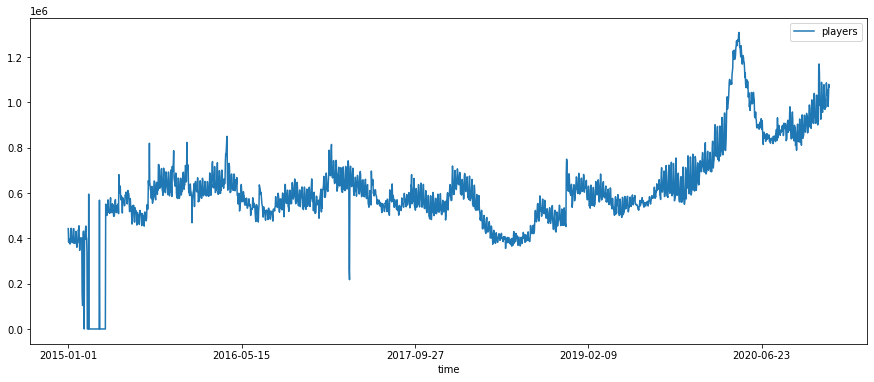

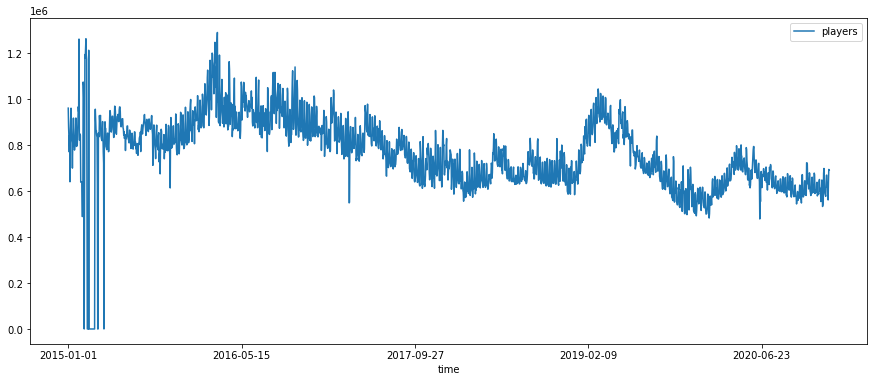

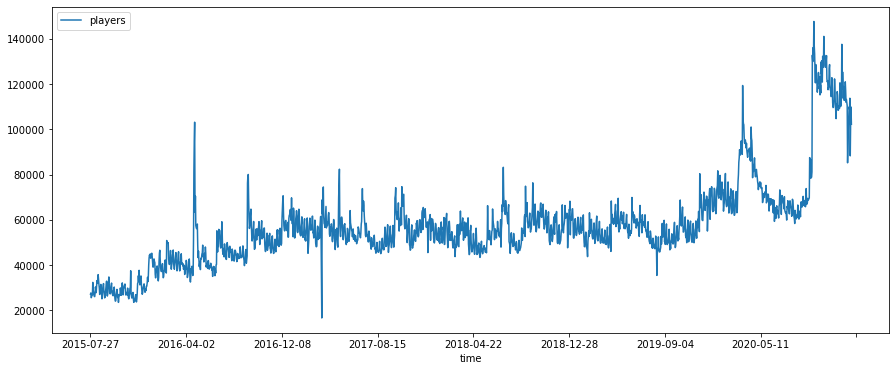

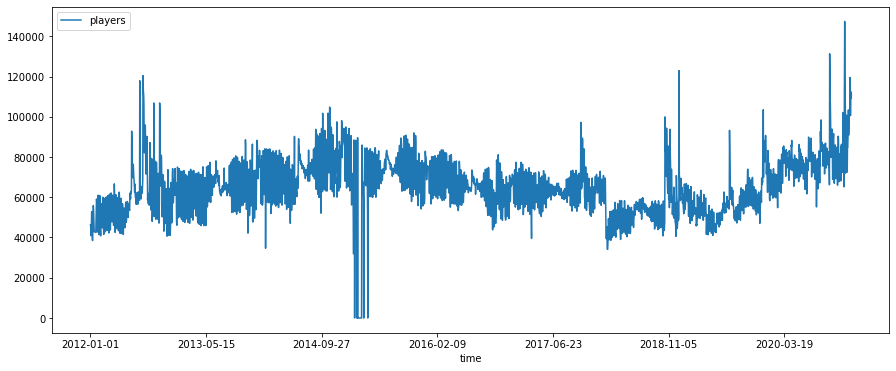

In [6]:
# we need to transform data before we even decide on our predictor column. Let's inspect players over time first. 


for df in ls:
    df_plot = df.copy()

    df_plot = df_plot.drop(columns = ['viewers', 'event', '%chg_players', '%chg_viewers'])
    df_plot = df_plot.drop(columns = ['time'])

    df_plot.plot(figsize = (15,6))
    plt.show()
    
    

In [7]:
# we handle discontinuities

def fill_zeroes(df, col):
    for i in range(len(df)):
        if df[col][i] == 0:
            df[col][i] = df[col][i-1]
    return df

ls = list(map(lambda df: fill_zeroes(df, col = 'players'), ls))


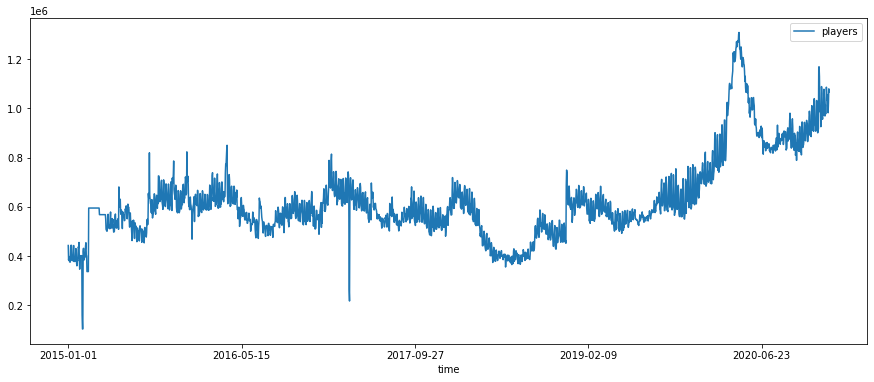

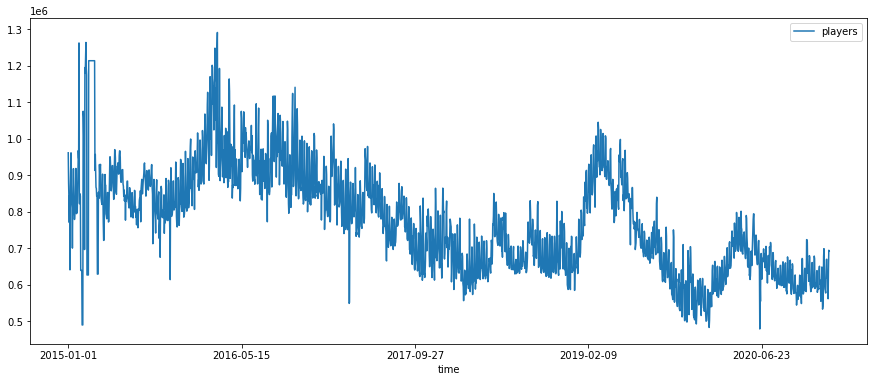

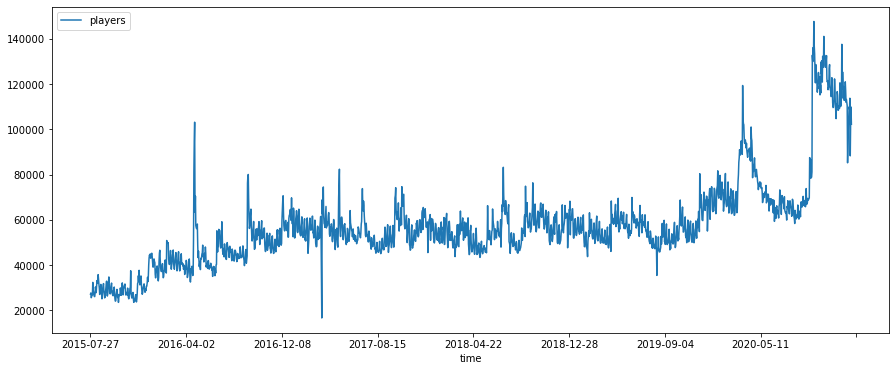

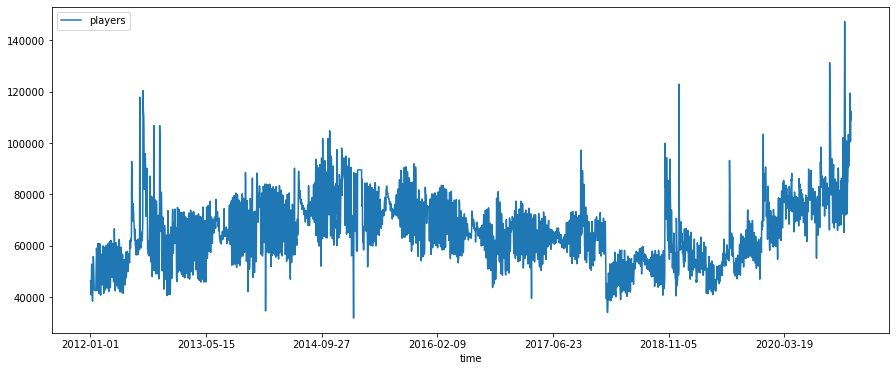

In [8]:
# and inspect to ensure this was successful

for i, df in enumerate(ls):
    df_plot = df.copy()
    df_plot.set_index(df_plot['time'], inplace = True)
    df_plot = df_plot.drop(columns = ['viewers', 'event', '%chg_players', '%chg_viewers'])
    df_plot = df_plot.drop(columns = ['time'])

    df_plot.plot(figsize = (15,6))
    plt.show()

In [9]:
# all of these games had major changes in number of players directly after their release, leading us to 
# model only player data a sufficient time after release. 

start_dates = [ "2016-01-01",
              "2016-01-01",
              "2016-01-01",
              "2013-01-01"]

trimmed_df_list = []

for i in range(0, 4):
    trimmed = ls[i].where(ls[i]['time'] >= start_dates[i]).dropna()
    trimmed_df_list.append(trimmed)
    

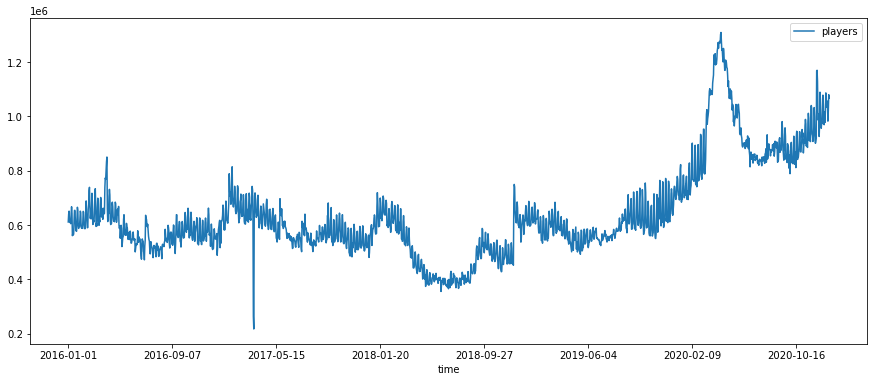

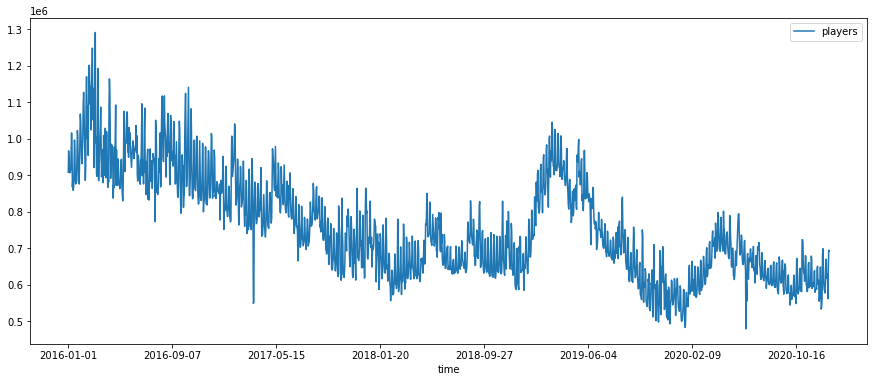

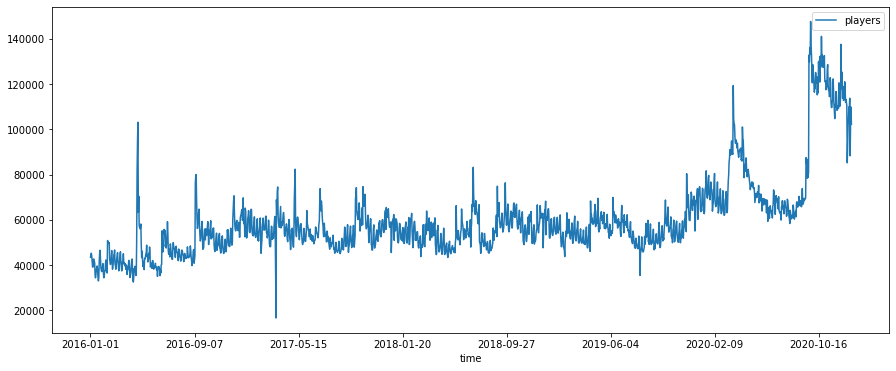

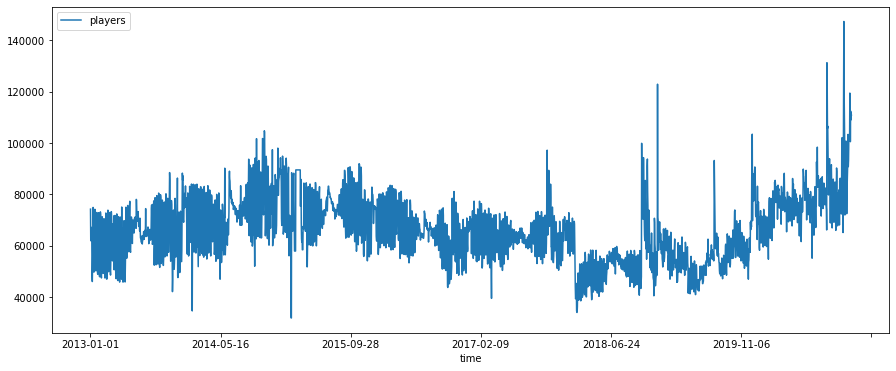

In [10]:
# we inspect our trimmed data

for i, df in enumerate(trimmed_df_list):
    df_plot = df.copy()
    df_plot.set_index(df_plot['time'], inplace = True)
    df_plot = df_plot.drop(columns = ['viewers', 'event', '%chg_players', '%chg_viewers'])
    df_plot = df_plot.drop(columns = ['time'])

    df_plot.plot(figsize = (15,6))
    plt.show()

ls_trimmed = trimmed_df_list

ls = trimmed_df_list


Looking much better, but we have more work to complete before this can be modelled. 
#### Stationarity

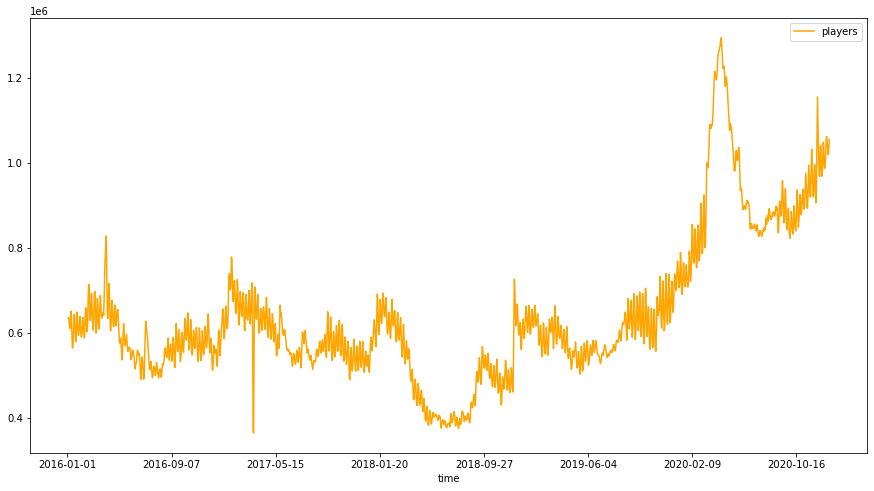

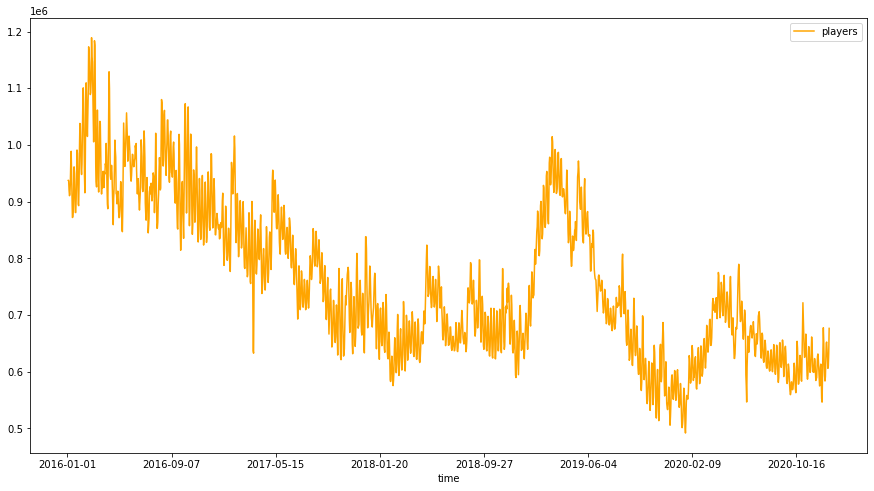

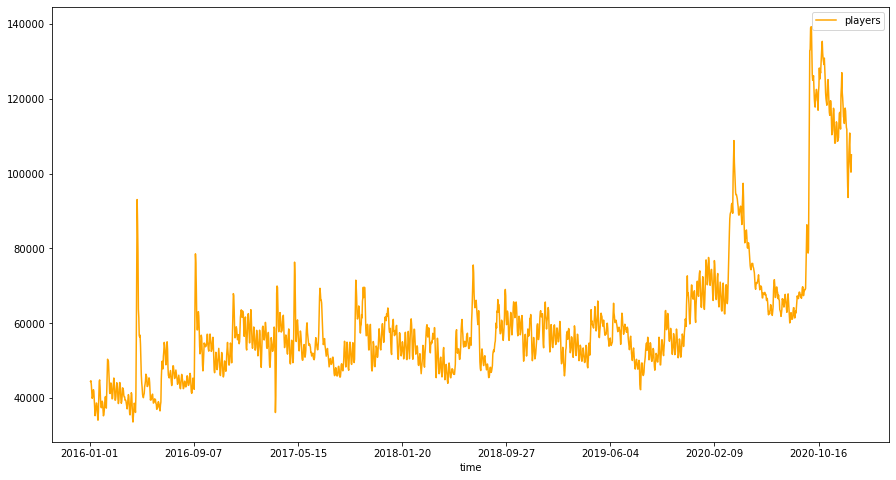

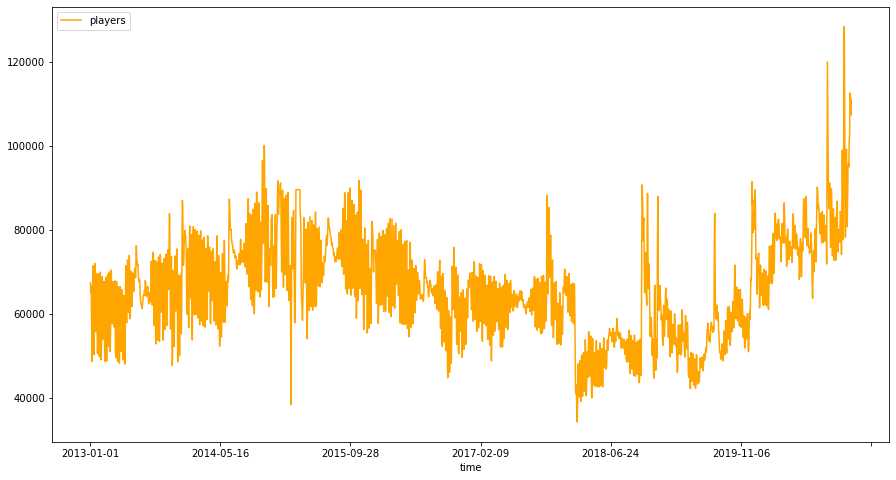

In [11]:
# we visualize our mean player count over time. If this plot has a trend, our data is not stationary. 

for df in ls:
    
    rolling_mean = pd.DataFrame(df['players'].rolling(window = 3).mean())
    
   # plt.plot(df['players'], color = 'blue', label = 'Players')
    rolling_mean.plot(color = 'orange', label = 'Rolling Average', figsize = (15, 8))

None of our games have stationary data, and we can address this in multiple ways. We can complete data transformations such as rolling mean transformations or differencing.

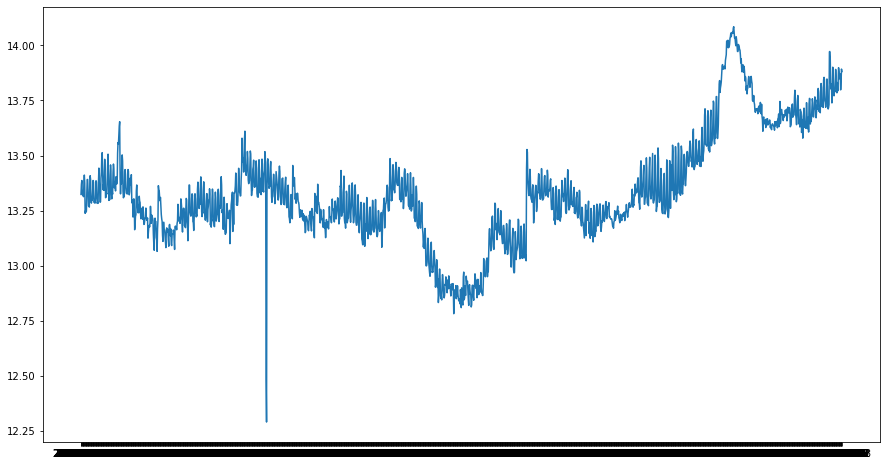

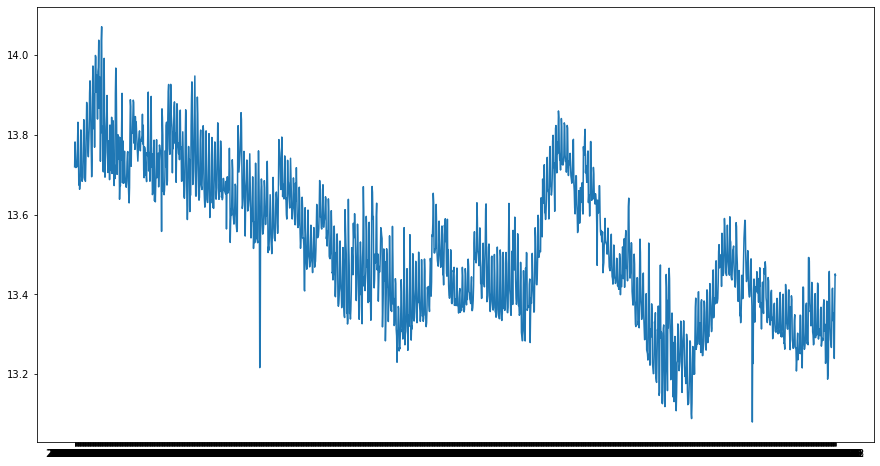

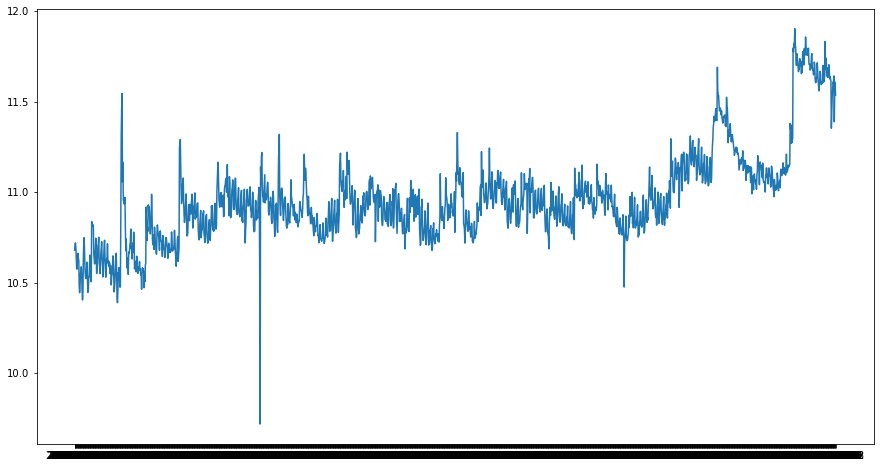

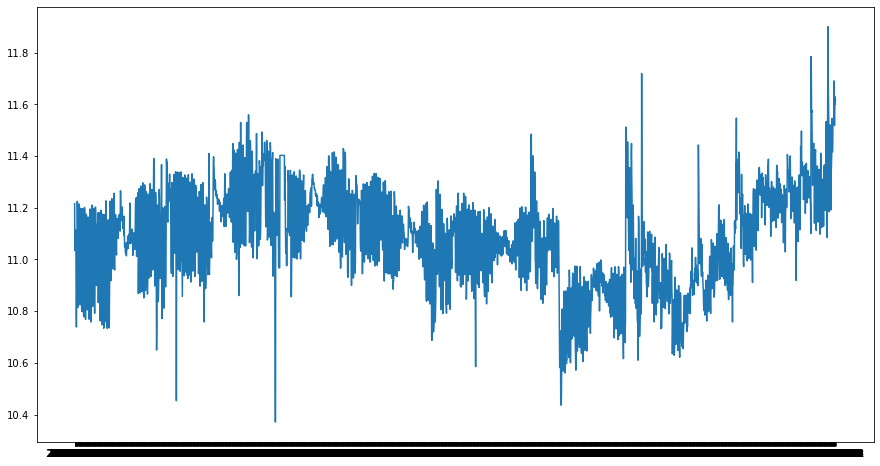

In [12]:
for df in ls:
    df['players_logged'] = np.log(df['players'])
    fig = plt.figure(figsize = (15, 8))
    plt.plot(df['players_logged'])

#### Rolling Mean Transformations

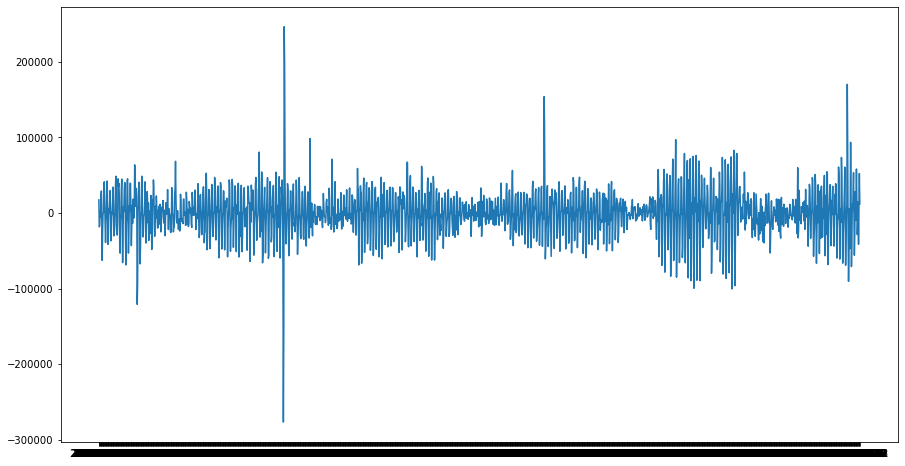

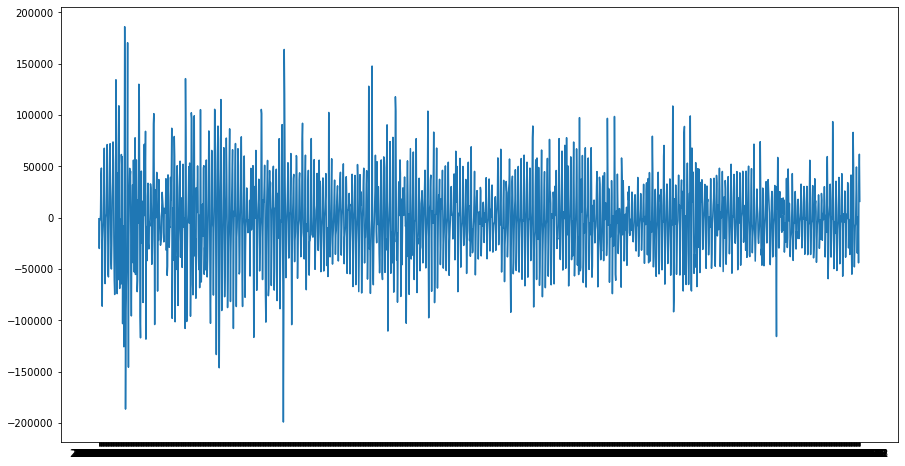

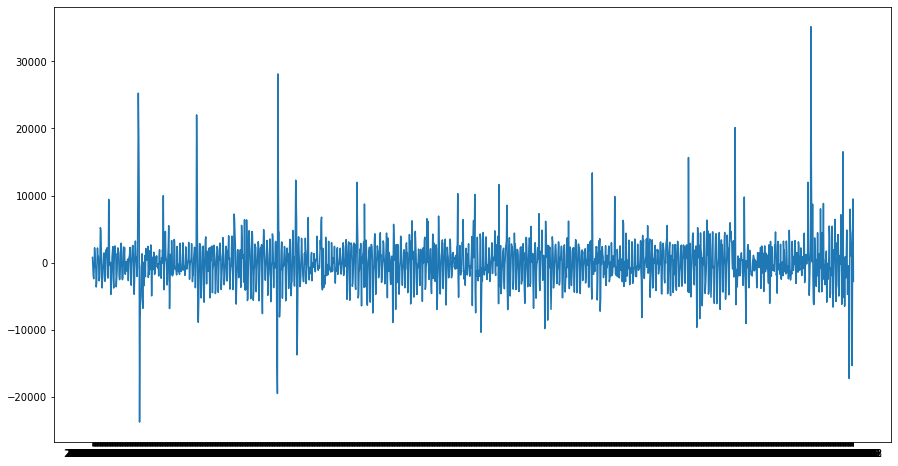

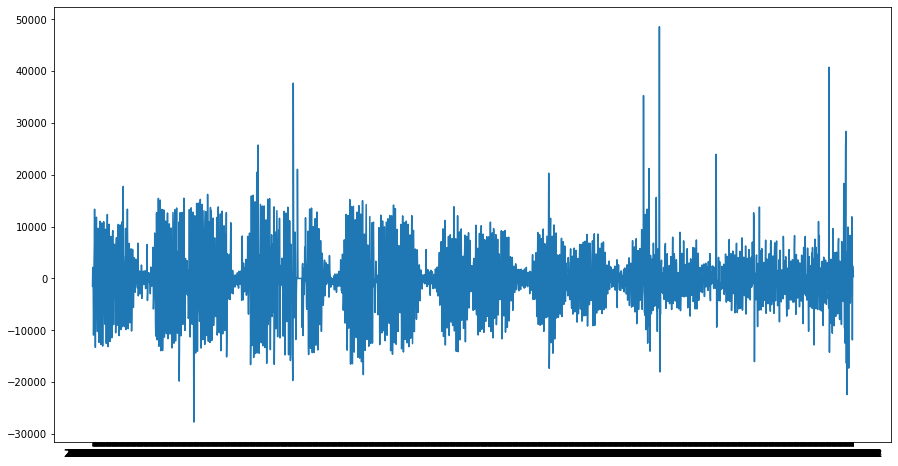

In [13]:
# we can stationize our data by subtracting the rolling mean from our 'players' column. This will force our data to be centered
# on the mean, even if the mean changes over time. 

for df in ls:
    rolling_mean = df['players'].rolling(window = 3).mean()
    df_plot = df.copy()
    df_plot['players_sub_mean'] = df['players'] - rolling_mean
    df_plot.dropna(inplace = True)
    fig = plt.figure(figsize = (15,8))
    plt.plot(df_plot['players_sub_mean'], label = 'Players Centered on Rolling Average')
    plt.show()
    

The data looks beautifully stationary now, though there are severe outliers in some cases. We'll address this after checking how differencing will make our data look.
#### Differencing

We have already constructed a column that represents a differencing technique. Our '%chg_players' represents this difference in the form of a percentage, but let's construct the raw difference for each games player counts. 

In [14]:
# using pandas diff function

for df in ls:
    df['difference'] = df['players'].diff(periods = 1)

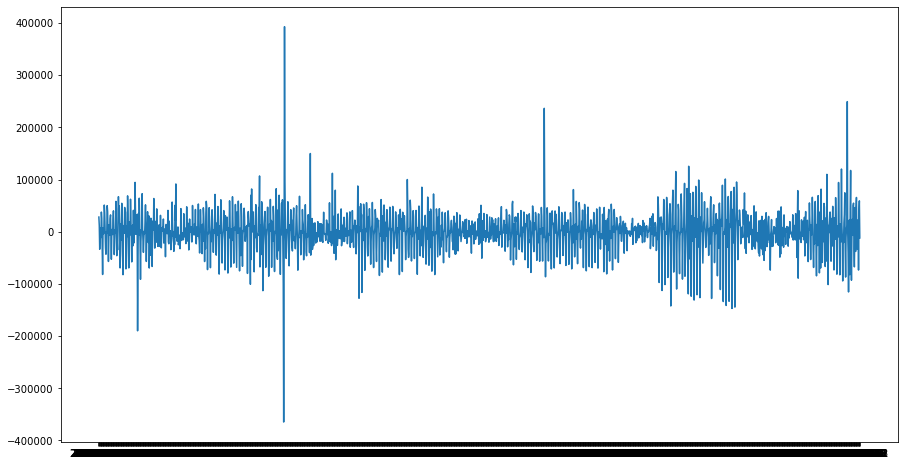

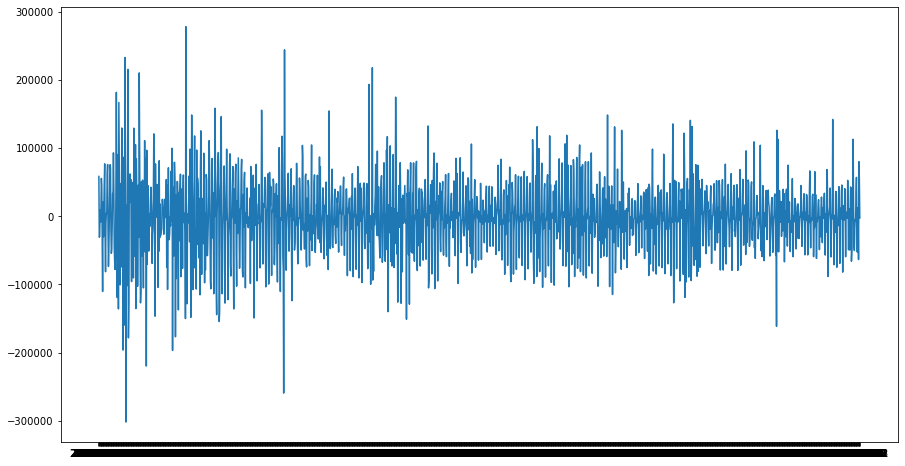

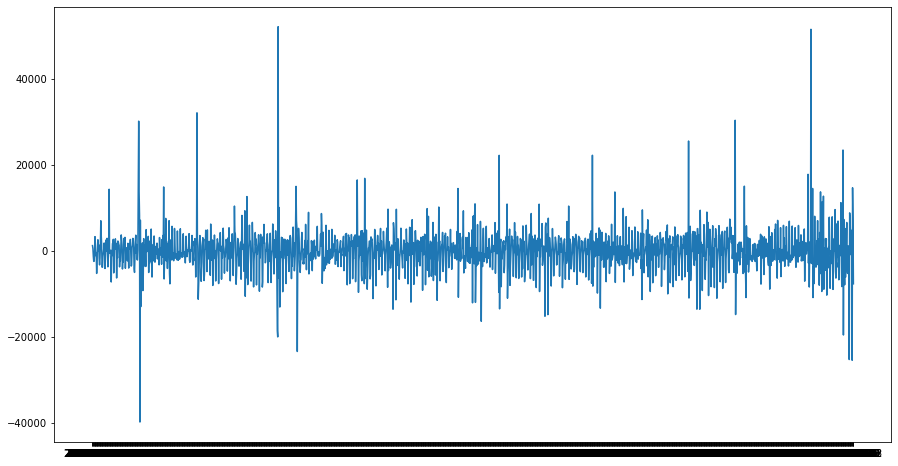

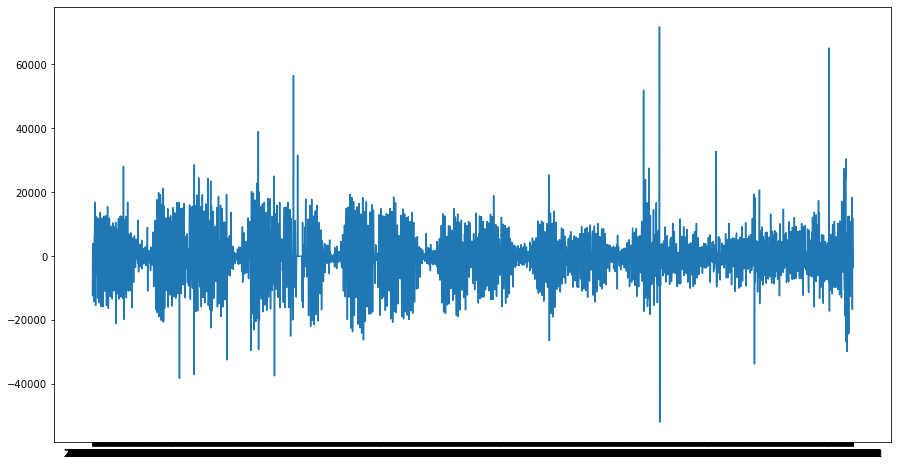

In [15]:
# basic differences

for df in ls:
    fig = plt.figure(figsize = (15, 8))
    plt.plot(df['difference'], label = 'Differences in Players')

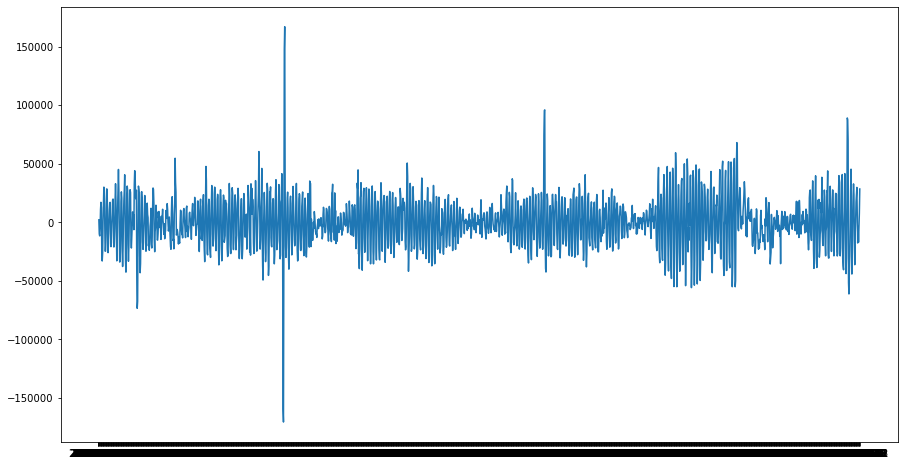

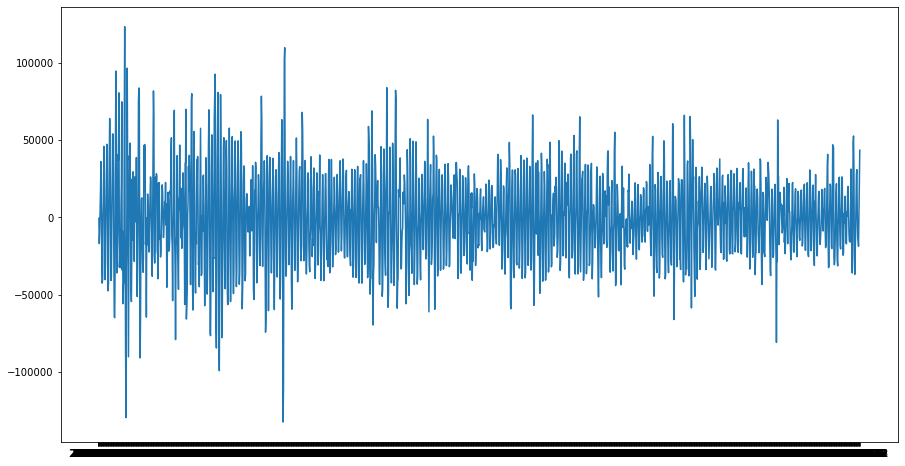

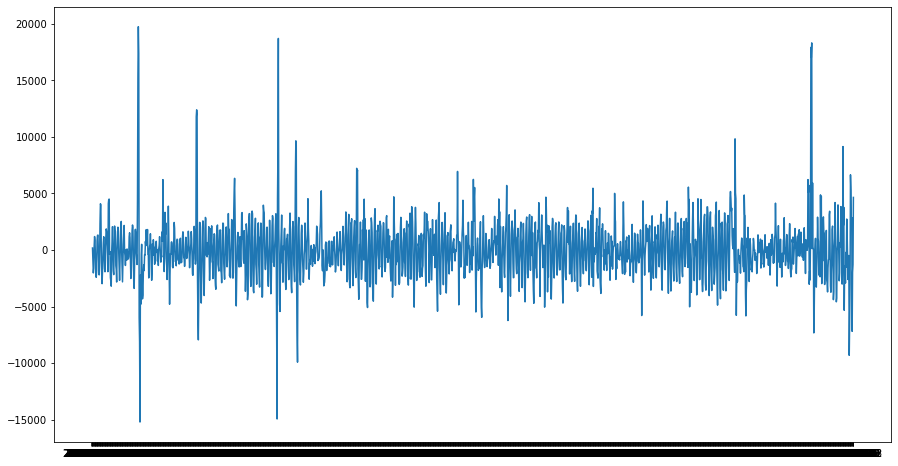

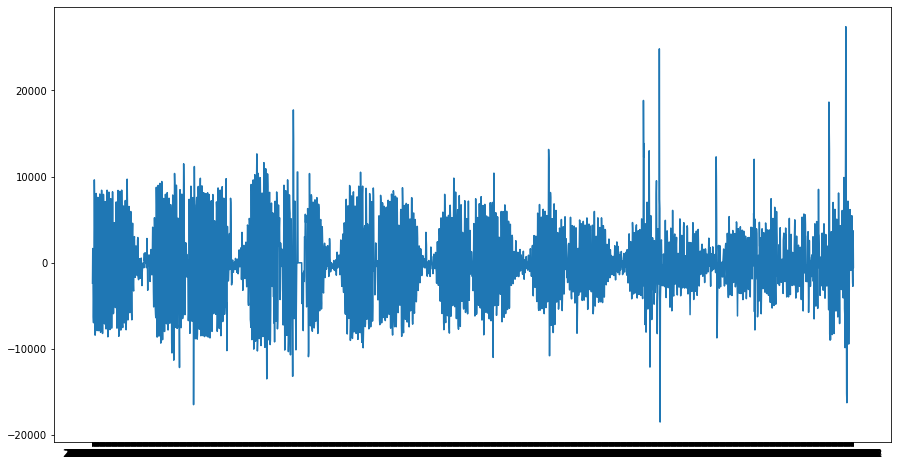

In [16]:
# differences of the rolling mean, though this will affect model interpretability

for df in ls:
    df['rolling_mean'] = df['players'].rolling(window = 3).mean()
    df['rolling_mean_diff'] = df['rolling_mean'].diff(periods = 1)
    fig = plt.figure(figsize = (15, 8))
    plt.plot(df['rolling_mean_diff'], label = 'Differences in Rolling Mean')



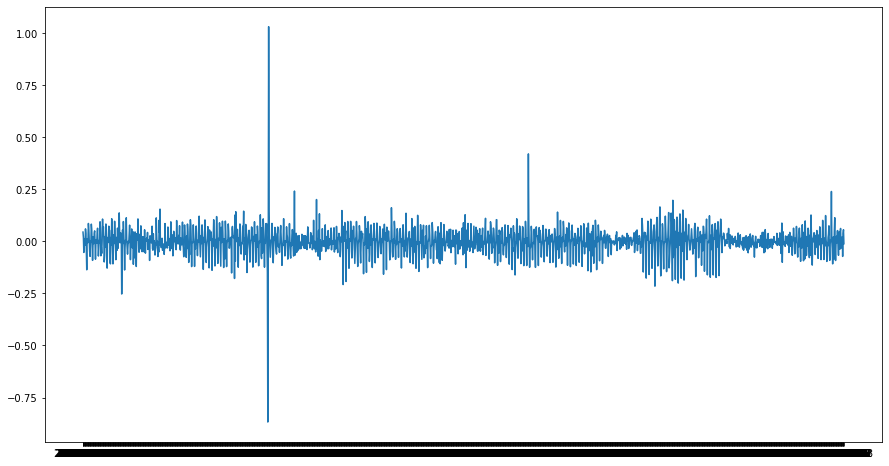

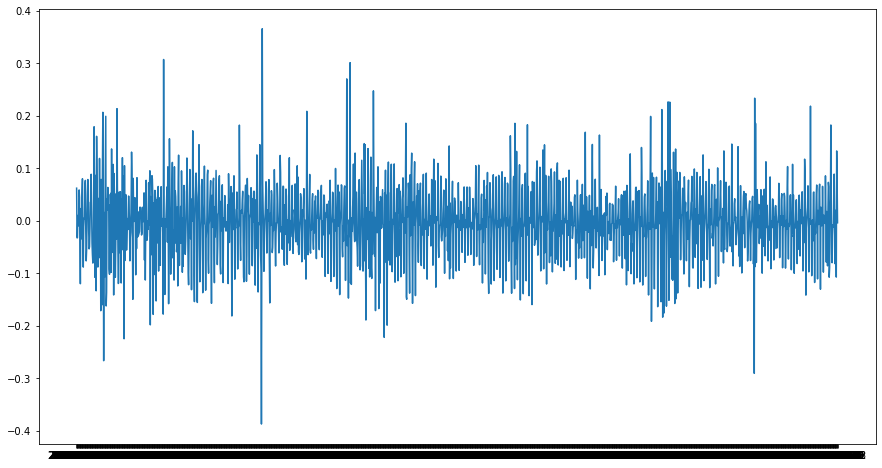

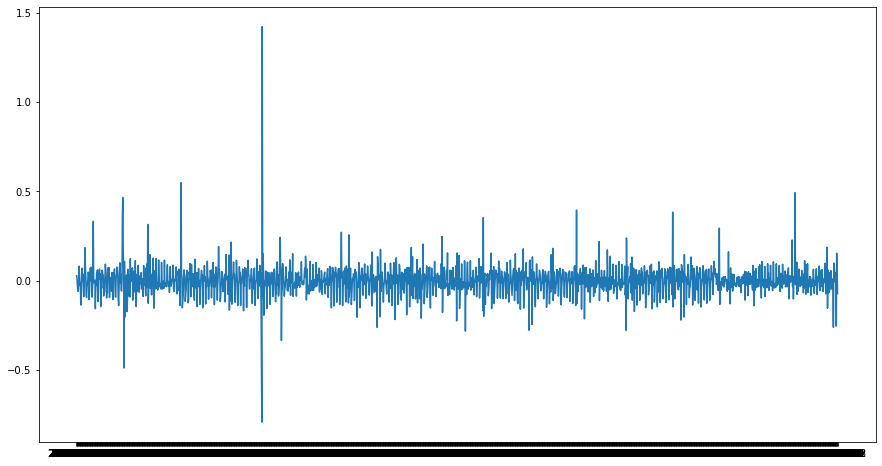

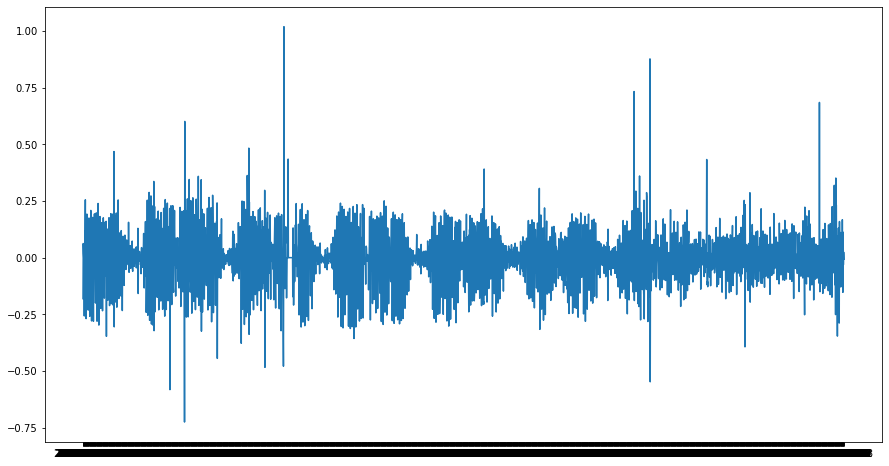

In [17]:
# differences in logged data

for df in ls:
    
    df['players_logged'] = np.log(df['players'])
    df['players_logged_diff'] = df['players_logged'].diff(periods = 1)
    
    fig = plt.figure(figsize = (15, 8))
    plt.plot(df['players_logged_diff'])

#### Outliers

We are going to deal with extreme outliers only, and we will continue on with using Logged Data, as this is normalized, on a small scale, and easily transformed back to player count.

In [18]:
# we need to keep a list of dataframes with outliers to use as a testing space.

ls_w_outliers = ls

In [19]:
ls = list(map(lambda df: df.dropna(), ls))

In [20]:
# outliers for our 'players_logged_differences'

plotting_lists = []

for df in ls:
    outlier_removed = []
    Inter_qr = scipy.stats.iqr(df['players_logged_diff'])
    mean = df['players_logged_diff'].mean()
    Q1 = df['players_logged_diff'].quantile([0.25])[0.25]
    Q3 = df['players_logged_diff'].quantile([0.75])[0.75]
    upper = Q3 + 3*Inter_qr
    lower = Q1 - 3*Inter_qr
    print(lower, upper)
    for i, val in enumerate(df['players_logged_diff']):
        if val > upper:
            outlier_removed.append(upper)
        elif val < lower:
            outlier_removed.append(lower)
        else:
            outlier_removed.append(val)
    plotting_lists.append(outlier_removed)

-0.19719134797564752 0.2014688531098061
-0.254719751483802 0.2648006319631122
-0.26011755209674803 0.2665679191113206
-0.34693047581169933 0.3571843387162348


In [21]:
for i in range(0, 4):
    ls[i]['outlier_removed_logged_diff'] = plotting_lists[i]

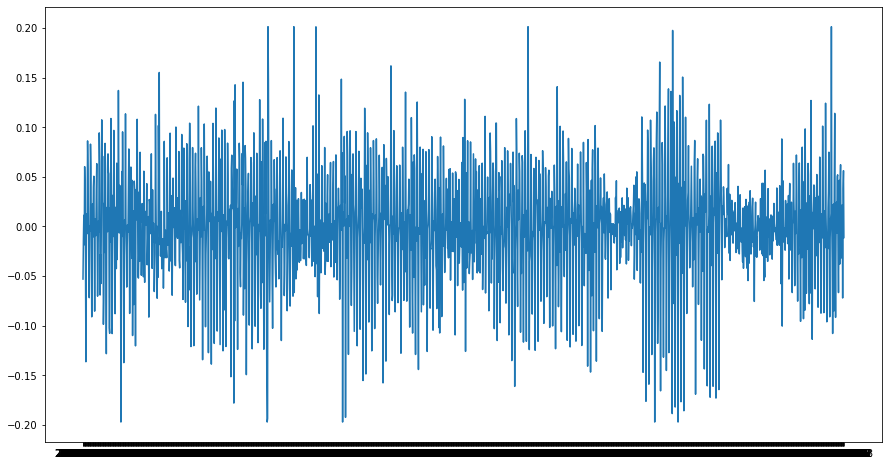

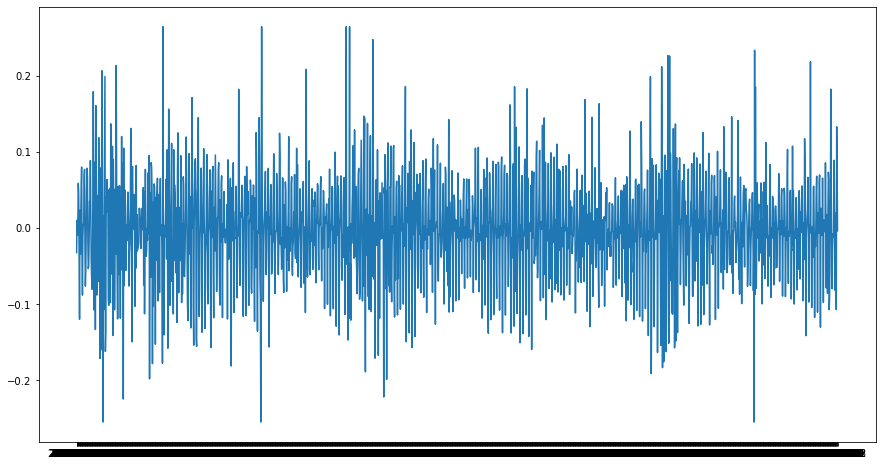

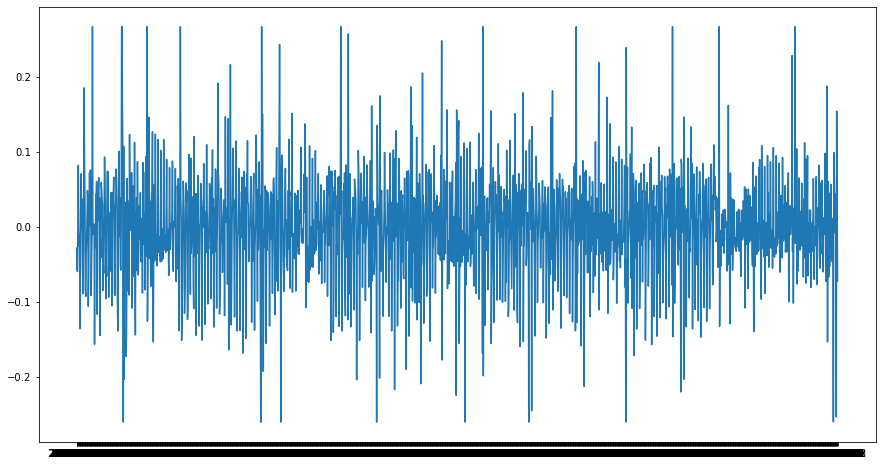

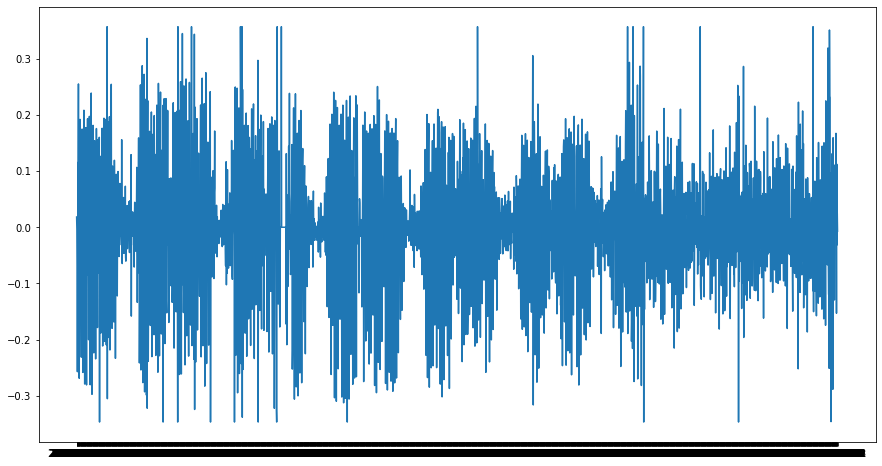

In [22]:
# let's see how this affected our data

for df in ls:
    fig = plt.figure(figsize = (15, 8))
    plt.plot(df['outlier_removed_logged_diff'])

We have beautifully stationary data, without outliers, and this is also very easy to return to our original player count!

This data is ready to be modelled. 

In [23]:
ls_prepped = ls

### b. Model Construction

We will be using a gridsearch to find the optimal model. However, we still have to manually find S, or the seasonal component of the model. 

In [24]:
# we define our predictor column and prepare it.

mod_ls = []

for df in ls:
    df_mod = pd.DataFrame()
    df_mod['ORLD'] = df['outlier_removed_logged_diff']
    mod_ls.append(df_mod)
mod_ls

[                ORLD
 time                
 2016-01-04 -0.053045
 2016-01-05 -0.013399
 2016-01-06  0.011285
 2016-01-07 -0.018439
 2016-01-08  0.060290
 ...              ...
 2020-12-30  0.021712
 2020-12-31 -0.072113
 2021-01-01  0.038074
 2021-01-02  0.056276
 2021-01-03 -0.011184
 
 [1827 rows x 1 columns],
                 ORLD
 time                
 2016-01-04 -0.032049
 2016-01-05  0.010455
 2016-01-06 -0.009395
 2016-01-07  0.008714
 2016-01-08  0.059022
 ...              ...
 2020-12-30 -0.007838
 2020-12-31 -0.106953
 2021-01-01  0.133289
 2021-01-02  0.078823
 2021-01-03 -0.003452
 
 [1827 rows x 1 columns],
                 ORLD
 time                
 2016-01-04 -0.028389
 2016-01-05 -0.056593
 2016-01-06 -0.059580
 2016-01-07 -0.000690
 2016-01-08  0.081842
 ...              ...
 2020-12-30  0.043204
 2020-12-31 -0.253279
 2021-01-01  0.154122
 2021-01-02  0.064612
 2021-01-03 -0.072147
 
 [1827 rows x 1 columns],
                 ORLD
 time                
 2013-01-04  0

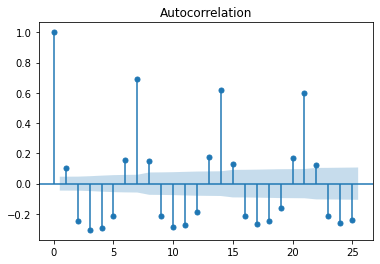

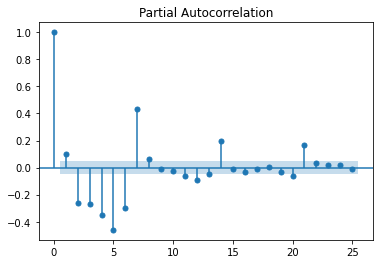

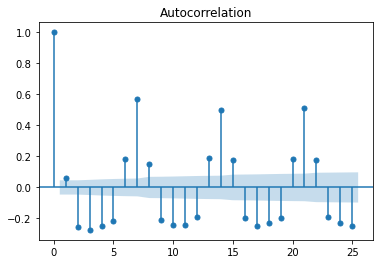

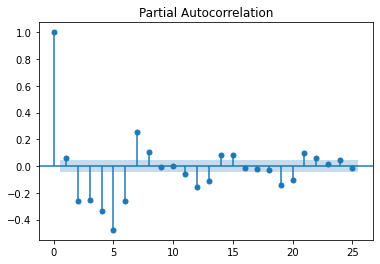

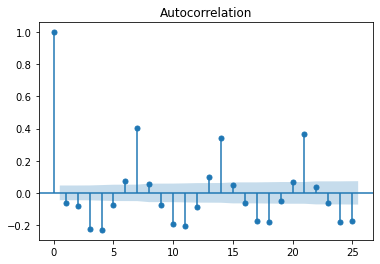

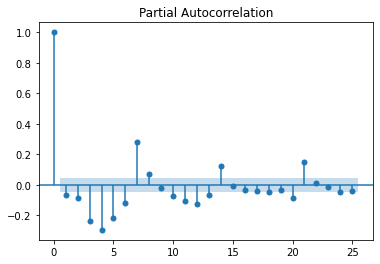

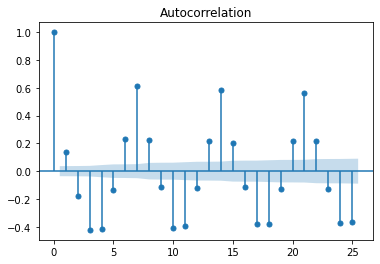

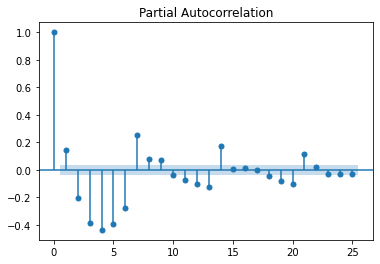

In [25]:
# we plot both ACF and PACF

for df in mod_ls:
    acf = plot_acf(df, lags = 25)
    pacf = plot_pacf(df, lags = 25)

The above plots suggest that our seasonal period for all our games is 7 days, or one week. 

In [26]:
# we establish our parameter variables

p = q = d = range(0, 2)
pdq = list(itertools.product(p, q, d))
pdqs = [(x[0], x[1], x[2], 7) for x in pdq]




In [27]:
ans_ls = []
for df in mod_ls:
    df = df.dropna()
    ans = []
    for comb in pdq:
        for combs in pdqs:
            mod = SARIMAX(df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df = ans_df.loc[ans_df['aic'].idxmin()].dropna()
    
    ans_ls.append(ans_df)

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-5319.79656103285
ARIMA (0, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5963.8084172788585
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-6176.389670036748


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-6687.78869832166
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6479.986959642231

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-6753.263792810134
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6451.418213903276

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-6696.774556206934
ARIMA (0, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-5347.073687532028


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5958.465712823787
ARIMA (0, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-6234.951913747273


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6718.222962266911


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6514.511934946098


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6781.555704907233


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6506.190821013026


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6726.07568515092
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4247.163411532349


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4722.316899130705
ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4642.3444435617685


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5259.418531044216
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5045.511598343801


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5314.044269958398
ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4943.864083432336

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5274.386867287449


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-5303.253195496164


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5947.526899170836


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-6158.736687330746


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6672.276529047591


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6465.918810917601


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6734.006020295015


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6437.355082658348


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6680.276959817633
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-5336.908474200677


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5961.8375043235155
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-6221.774496212145


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-6707.986866429541


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6503.956441661368


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-6773.854386601574
ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6486.281817364894


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-6716.102682988903


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-5538.504525527009


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-6191.246684996527


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-6462.996500291541


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6862.517259269434


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6713.3698949353875


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6931.05049993457


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6677.217908942332


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6873.979464277277
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4423.984487935719


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5024.0892832342515
ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5225.276967644128


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5723.641851069253


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5525.690175757487


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5785.349446512962


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5496.27616291049
ARIMA (1, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5730.749796401371


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-5320.3152623532005


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5945.559556379021


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-6203.635104353045


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6692.17141286127


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6489.879719528944


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6754.398265531588


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6475.338098975262


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6698.882124128659
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4696.913141339817


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5124.719442908886
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4967.958114681249


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5857.784003231767
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5400.532579794741


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5882.7277320658
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5290.822200899838


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5886.171346648289
ARIMA (0, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4704.34674737868


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5128.270072436249
ARIMA (0, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5138.241843002834


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6008.925019319564


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5496.986235957504


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6033.753693075418


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5474.138738862284


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6043.812763494321
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3544.6004232505165


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-3791.787784371824
ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3302.612031470819


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-4244.441293787869
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3904.3863062656355


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-4264.179767508574


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3630.8992787290235


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-4260.969191563296


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4681.004276009537


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5109.532029863278


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4951.43170006959


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5836.851053757649


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5387.06118489979


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5860.427037228068


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5277.3991786714


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5863.076728651109
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4701.869197843429


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5127.788335794459
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5080.614300088662


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5942.383233907654


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5453.038669265162


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5967.549628480557


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5399.050651552809


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5978.33746389642
ARIMA (1, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4991.513141128264

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5448.4536915171175


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5388.22246454345


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6136.784401872115


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5744.960065491774


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6161.165986686775


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5650.294159088363


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6170.500200744729
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3754.1112936887866


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4142.568736632002


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3979.4245790780997
ARIMA (1, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-4846.191015435208


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4402.098415357474


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-4867.589118145896


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4289.067116257495


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-4880.446822358256


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4685.964116181699


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5112.5125670425205


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5063.817499794761


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5921.519843802778


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5439.532602071933


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5945.184033326945


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5386.103760753378


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5954.683332372715
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4476.71835853458


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4680.471167263728
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4153.018468239938


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-4976.868357873254
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4786.048684583737


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5025.034455166169
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4548.446965560945


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-4988.707270311712
ARIMA (0, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4481.719392320254


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4708.602503559556
ARIMA (0, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4242.345799766349


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5036.973277481273


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-4837.210639083141


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5090.928026160845


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4639.047786406264


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5046.299809153856
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3094.9277337703184


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-3226.732393052609
ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2537.5560502359526


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-3445.574482377352
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3277.679509826729

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-3472.854173952593
ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-2940.5428825069894


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-3463.3915390570282


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4461.0308336293165


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4666.006097801252


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4139.010469044765


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-4958.75994762707


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-4772.919899935177


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5006.880962169258


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4535.433585369614


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-4967.967937580783
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4482.300935947635


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4703.138079852804
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4236.867482037034


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5029.127116021022


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4825.223373904328


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5082.013196616421


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4626.706097204718


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5037.418502778533


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4646.792307110221


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4861.716774755562


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4422.239774834014
ARIMA (1, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5099.941061389116


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-4970.56509888597


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5149.862874995288


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4756.588135276952


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5130.176257865364
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3595.792540344306


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-3804.864514033314
ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3294.0109910395768


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-4083.9339919650747


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3910.392378229014


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-4135.177853029966


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3687.8512870826717


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-4096.042335078231


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4466.610647788488


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4688.4283671145795


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4222.395049130679


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5011.184118923011


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-4812.072235767586


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5063.734046877388


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4614.132110996891


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5017.859179838428
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4706.952279980444


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5467.287472312458
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5460.924754070615


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-6641.51873404113
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6080.917717917214

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-6708.526637544116


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6154.972905313206


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-6642.148855779171
ARIMA (0, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4780.8384167326085


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5462.541816302139


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5715.766154670697


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6762.094154497849


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6204.200215587258


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6833.346126954862


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6350.6167147350925


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6762.516690038152
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3122.1535392335327


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-3519.334455661208
ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2839.1044828285217

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-4245.21294230811
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3772.775097494178


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-4293.830325340472


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3617.1973260635095
ARIMA (0, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-4249.522035433754


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4692.638583362086


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5453.8272990602745


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5445.715941643977


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6624.702415027386


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6067.853375284498


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6690.850303731633


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6141.880670298339


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6624.123252828506
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4763.11409518806


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5465.368260743568
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5615.108302606229


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-6710.026622276732


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6151.273044792436


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-6779.900868911365


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6264.987678622509


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-6709.535233624447


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-5130.725898333161


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5956.425376940735


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-6121.824104957576


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-7032.89779790978


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6623.2612779906885


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-7106.3525357828075


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6663.189621552073


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-7071.070728662366
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3422.902146771339

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4018.103553478987


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3821.0136461355432


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5042.940309100821


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4502.8085134685025


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5106.104449409622


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4530.539159435715
ARIMA (1, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5041.056545917253


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4748.743016055661


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5451.890347448421


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5599.8656537625475


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6693.407430798639


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6138.188295517177
ARIMA (1, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6762.705458928597


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6252.271710365838


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6691.748582522695


In [28]:
for i in range(0, 4):
    print(ans_ls[i])

pdq        (1, 0, 1)
pdqs    (1, 0, 1, 7)
aic         -6931.05
Name: 45, dtype: object
pdq        (1, 0, 1)
pdqs    (1, 1, 1, 7)
aic          -6170.5
Name: 47, dtype: object
pdq        (1, 0, 1)
pdqs    (1, 0, 1, 7)
aic         -5149.86
Name: 45, dtype: object
pdq        (1, 0, 1)
pdqs    (1, 0, 1, 7)
aic         -7106.35
Name: 45, dtype: object


Our optimized models, according to the grid search:

CS:GO --- ARIMA(1,0,1)x(1,0,1,7)

DOTA 2 --- ARIMA(1,0,1)x(1,1,1,7)

ROCKET LEAGUE --- ARIMA(1,0,1)x(1,1,1,7)

TEAM FORTRESS 2 --- ARIMA(1,0,1)x(1,0,1,7)

### c. Model Validation

In [29]:
# we generate validation statistics for our models

csgo_model = SARIMAX(mod_ls[0],
                    order = (1,0,1),
                    seasonal_order = (1,0,1,7),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
csgo_output = csgo_model.fit()
print(csgo_output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6626      0.023     28.962      0.000       0.618       0.707
ma.L1         -0.9116      0.015    -62.326      0.000      -0.940      -0.883
ar.S.L7        0.9378      0.009    101.855      0.000       0.920       0.956
ma.S.L7       -0.5621      0.018    -31.689      0.000      -0.597      -0.527
sigma2         0.0013   2.37e-05     54.150      0.000       0.001       0.001


In [30]:
dota_model = SARIMAX(mod_ls[1],
                    order = (1,0,1),
                    seasonal_order = (1,1,1,7),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
dota_output = dota_model.fit()
print(dota_output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4970      0.027     18.103      0.000       0.443       0.551
ma.L1         -0.8617      0.019    -46.350      0.000      -0.898      -0.825
ar.S.L7        0.1607      0.020      8.084      0.000       0.122       0.200
ma.S.L7       -1.0142      0.007   -146.996      0.000      -1.028      -1.001
sigma2         0.0018   4.06e-05     45.574      0.000       0.002       0.002


In [31]:
rl_model = SARIMAX(mod_ls[2],
                    order = (1,0,1),
                    seasonal_order = (1,1,1,7),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
rl_output = rl_model.fit()
print(rl_output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7094      0.022     32.991      0.000       0.667       0.752
ma.L1         -0.9189      0.015    -60.809      0.000      -0.949      -0.889
ar.S.L7        0.2141      0.020     10.792      0.000       0.175       0.253
ma.S.L7       -0.9722      0.008   -120.663      0.000      -0.988      -0.956
sigma2         0.0034   5.93e-05     57.090      0.000       0.003       0.004


In [32]:
tf_model = SARIMAX(mod_ls[3],
                    order = (1,0,1),
                    seasonal_order = (1,0,1,7),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
tf_output = tf_model.fit()
print(tf_output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5961      0.016     37.118      0.000       0.565       0.628
ma.L1         -1.1015      0.012    -92.277      0.000      -1.125      -1.078
ar.S.L7        0.9557      0.006    163.436      0.000       0.944       0.967
ma.S.L7       -0.6750      0.015    -45.753      0.000      -0.704      -0.646
sigma2         0.0042      0.000     35.784      0.000       0.004       0.004


In [33]:
models = [csgo_model, dota_model, rl_model, tf_model]
outputs = [csgo_output, dota_output, rl_output, tf_output]

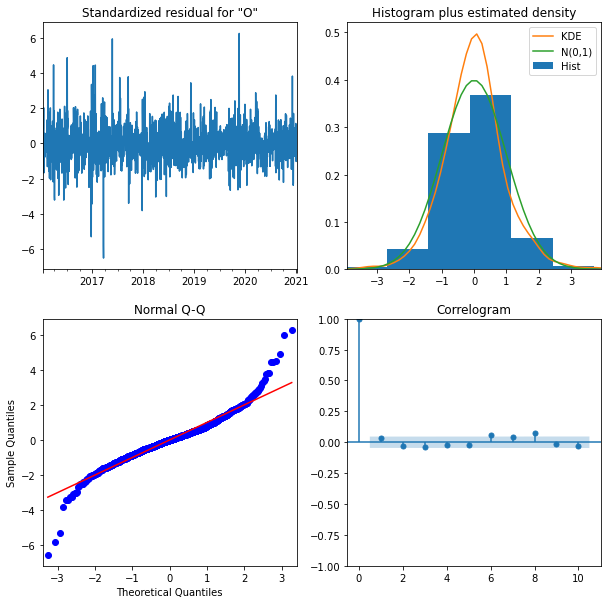

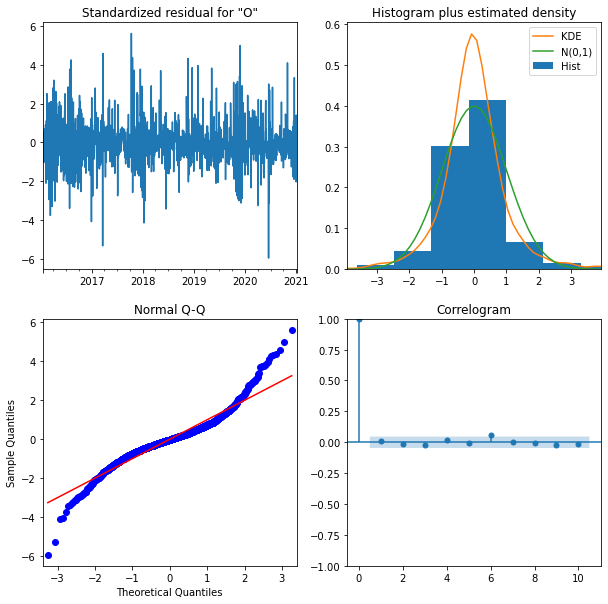

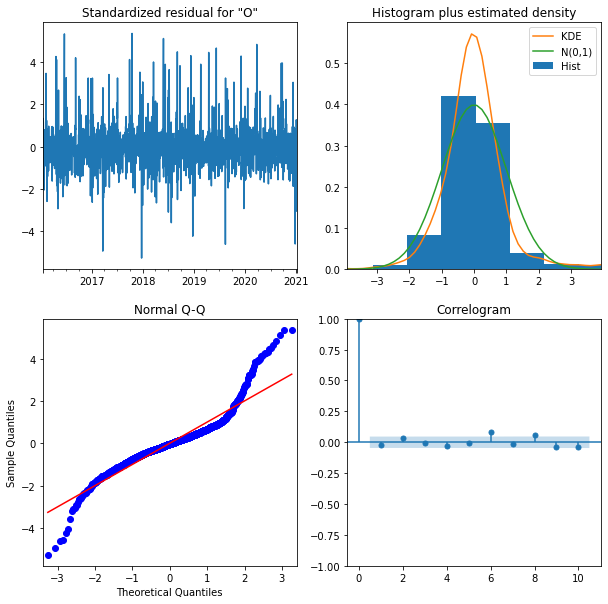

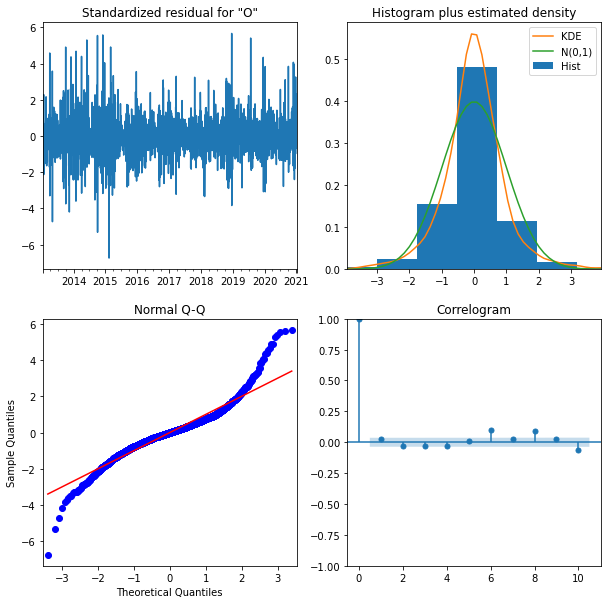

In [34]:
for i, output in enumerate(outputs):
    
    output.plot_diagnostics(figsize = (10, 10))
    

#### Forecasting our Basic Models

We will be forecasting from 2020-12-15 to present, and visualizing the full month of December 2020 for comparison to our original values.  


In [35]:
# we construct predictions

predictions = list(map(lambda output: output.get_prediction(start = pd.to_datetime('2020-12-15'), dynamic = False), outputs))
pred_conf = list(map(lambda pred: pred.conf_int(), predictions))



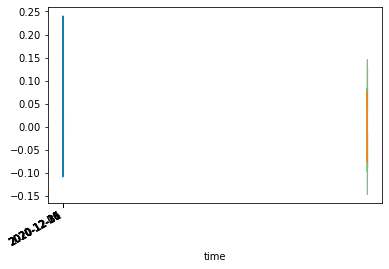

In [36]:
ax = ls_w_outliers[0]['2020-12-01':]['players_logged_diff'].plot(label = "Truth")

predictions[0].predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf[0].index,
                   pred_conf[0].iloc[:,0],
                   pred_conf[0].iloc[:,1], color = 'g', alpha = 0.5)

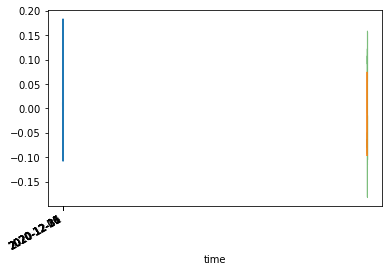

In [37]:
ax = ls_w_outliers[1]['2020-12-01':]['players_logged_diff'].plot(label = "Truth")

predictions[1].predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf[1].index,
                   pred_conf[1].iloc[:,0],
                   pred_conf[1].iloc[:,1], color = 'g', alpha = 0.5)

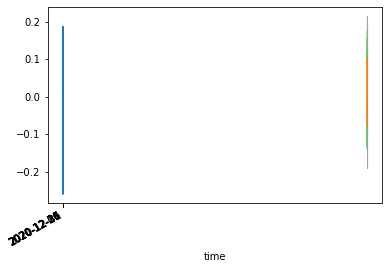

In [38]:
ax = ls_w_outliers[2]['2020-12-01':]['players_logged_diff'].plot(label = "Truth")

predictions[2].predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf[2].index,
                   pred_conf[2].iloc[:,0],
                   pred_conf[2].iloc[:,1], color = 'g', alpha = 0.5)

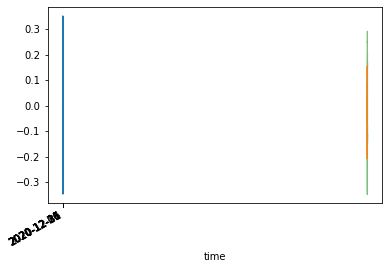

In [39]:
ax = ls_w_outliers[3]['2020-12-01':]['players_logged_diff'].plot(label = "Truth")

predictions[3].predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf[3].index,
                   pred_conf[3].iloc[:,0],
                   pred_conf[3].iloc[:,1], color = 'g', alpha = 0.5)

In [40]:
for i in range(0, 4):
    forecasted = predictions[i].predicted_mean
    truth = ls_w_outliers[i]["2020-01-01":]['players_logged_diff']
    error = forecasted - truth
    mse = (error ** 2).mean()
    print(mse)

0.00034872304928474713
0.0023935113945104253
0.0067399801869279154
0.0071421259430818175


### Part 1 Conclusions:

We constructed 4 models from the dataframes we have, and summary statistics show that these can all be said to be viable models in predicting the logged differences in player counts. P-values are lower than 0.05, and mean squared error values are also very low, though this is without any support until we can compare these values to those of other models. 

## Part 2: Amalgamized Modelling

The goal in this section of our project is to construct a model from all of our dataframes available. We will hopefully gain a model that is able to predict  for all of our games to an accuracy comparable to the accuracy values gained for individual models, found in part 1 above. 

We can construct this model by simply taking the average of all of our dataframe values. In this case we would be forced to scale all values, so we could feasibly use our % change feature for this process.  

### Taking mean values of dataframes
We are going to be taking the mean of '%_chg_players', but we have to prepare this data first. 
### Preparation

In [41]:
# resetting our dataframes to start fresh from when we trimmed the dataframe dates. 

ls = trimmed_df_list

ls = list(map(lambda df: df.dropna(), ls))

In [42]:
# in order to take the mean, we have to have all our series begin at the same time. We only have to alter team fortress 2

ls[3] = ls[3].where(ls[3]['time'] >= "2016-01-01").dropna()

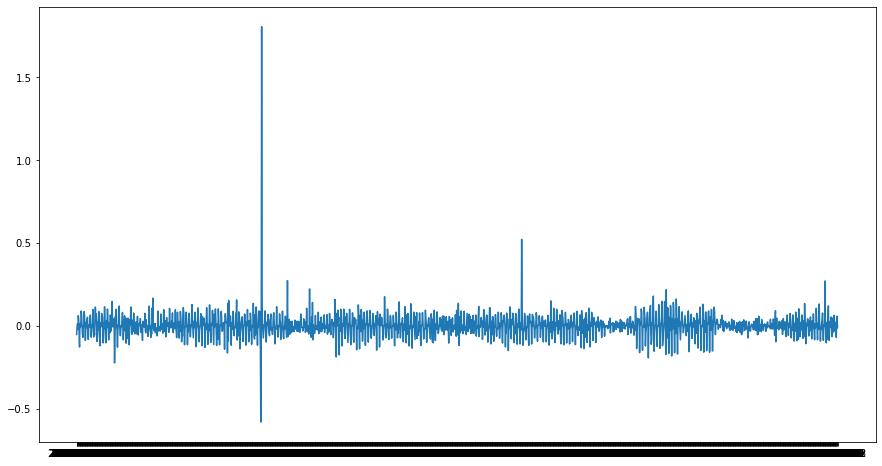

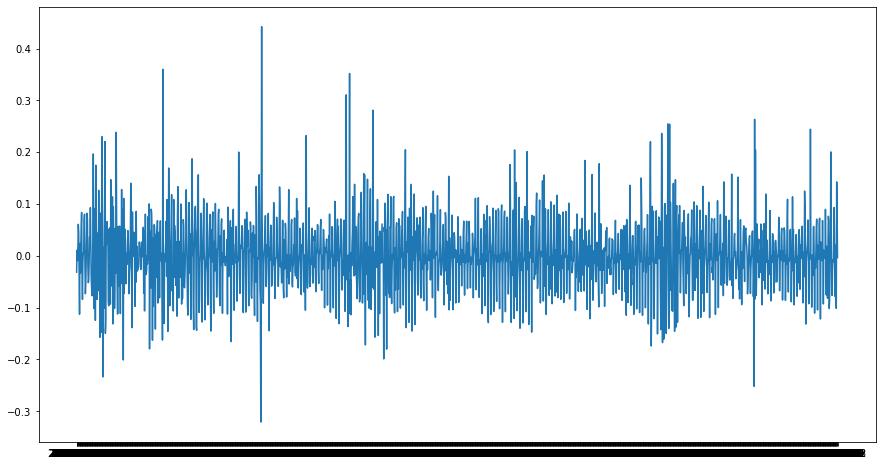

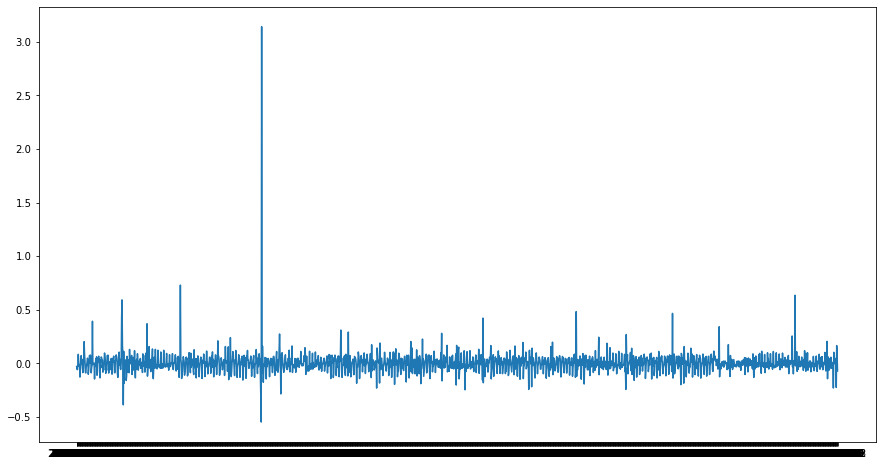

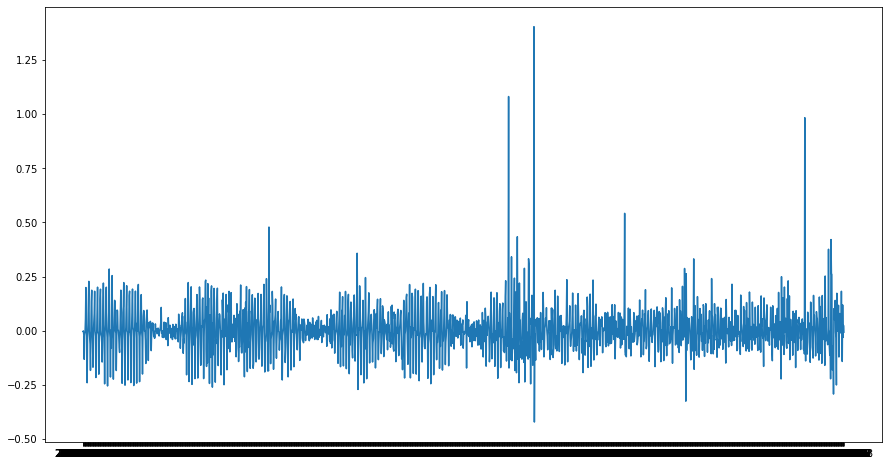

In [43]:
# visualizing this feature
for df in ls:
    fig = plt.figure(figsize = (15, 8))
    plt.plot(df['%chg_players'])

In [44]:
# we should average our data before removing outliers

average_pc = []

for i in range(len(ls[0])):
    pc = '%chg_players'
    average_at_i = np.array([ls[0][pc][i], ls[1][pc][i], ls[2][pc][i], ls[3][pc][i]]).mean() 
    average_pc.append(average_at_i)
df_model = ls[0].copy()
df_model["mean_%chg_players"] = average_pc
df_model = df_model['mean_%chg_players']

df_model_w_outliers = pd.DataFrame(df_model)
df_model = pd.DataFrame(df_model)
df_model

,mean_%chg_players
time,
2016-01-04,-0.028664
2016-01-05,-0.014695
2016-01-06,-0.019099
2016-01-07,-0.035620
2016-01-08,0.045607
...,...
2020-12-30,0.011848
2020-12-31,-0.053178
2021-01-01,0.082226


In [45]:
# while our data is already stationary, we have to address outliers, much like we did before with our logged differences. 

outlier_removed = []

IQR = scipy.stats.iqr(df_model)
mean = df_model.mean()
quantiles = df_model['mean_%chg_players'].quantile([0.25, 0.75])
Q1 = quantiles[0.25]
Q3 = quantiles[0.75]
upper = Q3 + 3*IQR
lower = Q1 - 3*IQR
for val in df_model['mean_%chg_players']:
        if val > upper:
            outlier_removed.append(upper)
        elif val < lower:
            outlier_removed.append(lower)
        else:
            outlier_removed.append(val)
df_model['PCOR'] = outlier_removed

df_model = df_model.drop(columns = ['mean_%chg_players'])

df_model



,PCOR
time,
2016-01-04,-0.028664
2016-01-05,-0.014695
2016-01-06,-0.019099
2016-01-07,-0.035620
2016-01-08,0.045607
...,...
2020-12-30,0.011848
2020-12-31,-0.053178
2021-01-01,0.082226


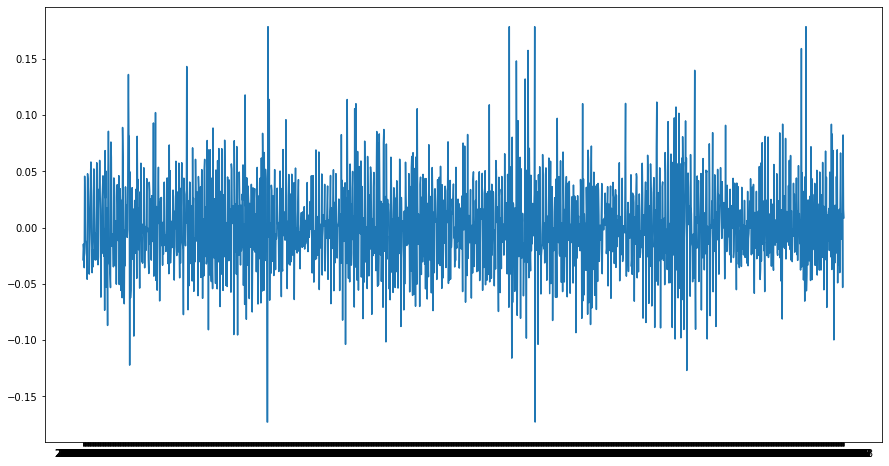

In [46]:
# inspecting how this impacted our visualizations

fig = plt.figure(figsize = (15, 8))

plt.plot(df_model)

Data is ready to be modelled!

As before, we need to first ensure that our seasonality was not affected by our transformations so far. 

### Modelling

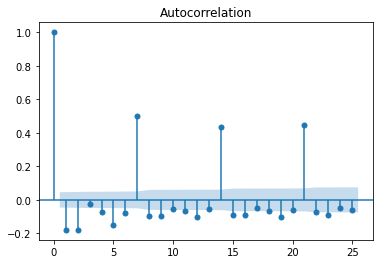

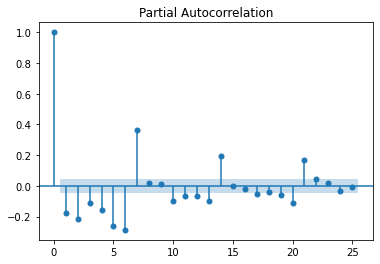

In [47]:
# plotting acf and pacf, showing that our seasonality is retained at s = 7

acf = plot_acf(df_model, lags = 25)
pacf = plot_pacf(df_model, lags = 25)

In [48]:
# defining our parameters for our gridsearch.

p = d = q = range(0, 2)
pdq = list(itertools.product(p, q, d))
pdqs = [(x[0], x[1], x[2], 7) for x in pdq]

In [49]:

models = []
for comb in pdq:
    for combs in pdqs:
        model = SARIMAX(df_model, 
                       order = comb,
                       seasonal_order = combs,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
        output = model.fit()
        models.append([comb, combs, output.aic])
        print('ARIMA {} X {} : AIC Calculated = {}'.format(comb, combs, round(output.aic, 2)))
models_df = pd.DataFrame(models, columns = ['pdq', 'pdqs', 'aic'])
best_model = models_df.loc[models_df['aic'].idxmin()].dropna()
    

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -6551.71
ARIMA (0, 0, 0) X (0, 0, 1, 7) : AIC Calculated = -6865.12
ARIMA (0, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -6540.39


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (0, 1, 1, 7) : AIC Calculated = -7329.74
ARIMA (0, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -7059.5

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.




ARIMA (0, 0, 0) X (1, 0, 1, 7) : AIC Calculated = -7381.24
ARIMA (0, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -6893.17

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (1, 1, 1, 7) : AIC Calculated = -7337.5
ARIMA (0, 0, 1) X (0, 0, 0, 7) : AIC Calculated = -6643.29


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (0, 0, 1) X (0, 0, 1, 7) : AIC Calculated = -6947.67
ARIMA (0, 0, 1) X (0, 1, 0, 7) : AIC Calculated = -6616.64


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (0, 1, 1, 7) : AIC Calculated = -7430.9


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 0, 0, 7) : AIC Calculated = -7144.02


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 0, 1, 7) : AIC Calculated = -7482.25


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 1, 0, 7) : AIC Calculated = -6984.94


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 1, 1, 7) : AIC Calculated = -7434.69
ARIMA (0, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -4990.92


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (0, 0, 1, 7) : AIC Calculated = -5302.63
ARIMA (0, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -4966.88


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (0, 1, 1, 7) : AIC Calculated = -5751.83
ARIMA (0, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -5490.13


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 0, 1, 7) : AIC Calculated = -5794.19


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -5317.61


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 1, 1, 7) : AIC Calculated = -5766.01


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 0, 0, 7) : AIC Calculated = -6543.56


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 0, 1, 7) : AIC Calculated = -6853.97


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 1, 0, 7) : AIC Calculated = -6522.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 1, 1, 7) : AIC Calculated = -7309.61


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 0, 0, 7) : AIC Calculated = -7048.51


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 0, 1, 7) : AIC Calculated = -7360.1


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 1, 0, 7) : AIC Calculated = -6878.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 1, 1, 7) : AIC Calculated = -7315.62
ARIMA (1, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -6605.12


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (0, 0, 1, 7) : AIC Calculated = -6921.61
ARIMA (1, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -6601.89


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (0, 1, 1, 7) : AIC Calculated = -7396.28


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -7113.71


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 0, 1, 7) : AIC Calculated = -7449.08


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -6953.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 1, 1, 7) : AIC Calculated = -7401.61


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 0, 0, 7) : AIC Calculated = -6743.28


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 0, 1, 7) : AIC Calculated = -7032.68


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 1, 0, 7) : AIC Calculated = -6819.22


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 1, 1, 7) : AIC Calculated = -7484.93


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 0, 0, 7) : AIC Calculated = -7219.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 0, 1, 7) : AIC Calculated = -7533.6


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 1, 0, 7) : AIC Calculated = -7111.56


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 1, 1, 7) : AIC Calculated = -7494.12
ARIMA (1, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -5515.94


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (0, 0, 1, 7) : AIC Calculated = -5860.89


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -5571.2
ARIMA (1, 1, 0) X (0, 1, 1, 7) : AIC Calculated = -6297.69


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -6064.35


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 0, 1, 7) : AIC Calculated = -6353.05
ARIMA (1, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -5896.47


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 1, 1, 7) : AIC Calculated = -6307.68


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 0, 0, 7) : AIC Calculated = -6601.08


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 0, 1, 7) : AIC Calculated = -6913.21


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 1, 0, 7) : AIC Calculated = -6584.17


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 1, 1, 7) : AIC Calculated = -7375.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 0, 0, 7) : AIC Calculated = -7104.17


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 0, 1, 7) : AIC Calculated = -7428.07


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 1, 0, 7) : AIC Calculated = -6940.18


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 1, 1, 7) : AIC Calculated = -7379.62


In [50]:
print(best_model)

pdq        (1, 0, 1)
pdqs    (1, 0, 1, 7)
aic          -7533.6
Name: 45, dtype: object


### Validation

In [51]:
# we generate summary stats for the model

mean_model = SARIMAX(df_model_w_outliers,
             order = (1,0,1),
             seasonal_order = (1,0,1,7),
             enforce_stationarity = False,
             enforce_invertibility = False)
output = mean_model.fit()
print(output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4537      0.026     17.535      0.000       0.403       0.504
ma.L1         -0.6914      0.024    -29.401      0.000      -0.737      -0.645
ar.S.L7        0.9827      0.007    137.144      0.000       0.969       0.997
ma.S.L7       -0.8997      0.013    -71.085      0.000      -0.925      -0.875
sigma2         0.0020   9.62e-06    206.307      0.000       0.002       0.002


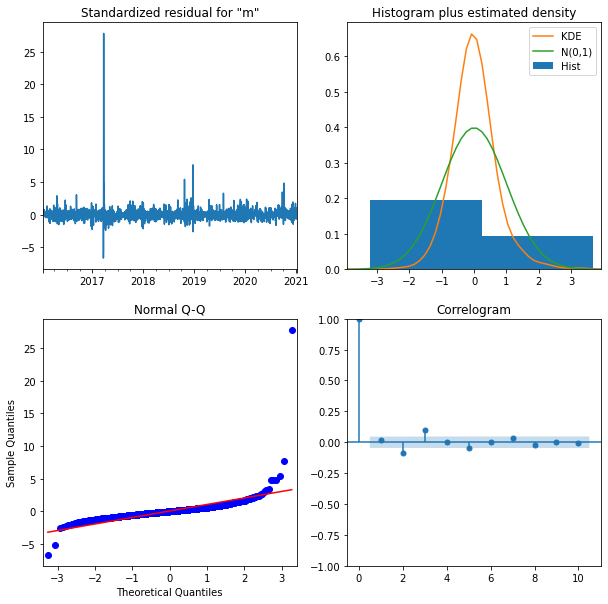

In [52]:
# we visualize validation plots

output.plot_diagnostics(figsize = (10, 10))
plt.show()

#### Forecasting 

We will forecast and calculate the mean squared error for each dataframe, using our constructed model. 

In [53]:
# we generate predictions

pred = output.get_prediction(start = pd.to_datetime('2020-12-15'))
pred_conf = pred.conf_int()

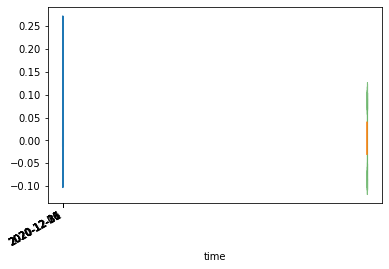

In [54]:
# and visualize the forecasts for each of our dataframes

ax = ls_w_outliers[0]['2020-12-01':]['%chg_players'].plot(label = "Truth")

pred.predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:,0],
                   pred_conf.iloc[:,1], color = 'g', alpha = 0.5)
plt.show()

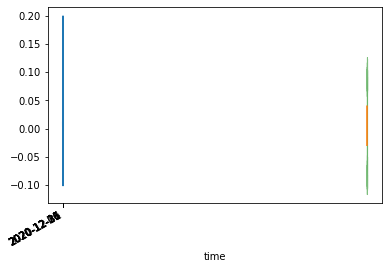

In [55]:
ax = ls_w_outliers[1]['2020-12-01':]['%chg_players'].plot(label = "Truth")

pred.predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:,0],
                   pred_conf.iloc[:,1], color = 'g', alpha = 0.5)
plt.show()

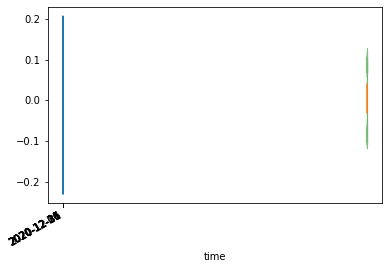

In [56]:
ax = ls_w_outliers[2]['2020-12-01':]['%chg_players'].plot(label = "Truth")

pred.predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:,0],
                   pred_conf.iloc[:,1], color = 'g', alpha = 0.5)
plt.show()

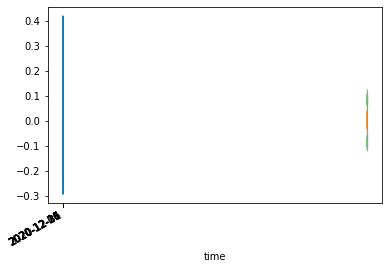

In [57]:
ax = ls_w_outliers[3]['2020-12-01':]['%chg_players'].plot(label = "Truth")

pred.predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:,0],
                   pred_conf.iloc[:,1], color = 'g', alpha = 0.5)
plt.show()

In [58]:
# finally, we calculate the MSE for each of these forecasts. 

for df in ls_w_outliers:
    forecasted = pred.predicted_mean
    truth = df["2020-12-15":]['%chg_players']
    mse = ((forecasted - truth) ** 2).mean()
    print(mse)

0.0016463180707760462
0.0053211835092316934
0.007631776124651386
0.01296918461268468


### Conclusions on Amalgamized Modelling

We constructed one model from the mean change in players for all of our games. This model's summary statistics show that it is more viable than our basic models in part 1, due to the fact that our validation visualizations, namely the QQ plot suggesting that residuals in this model are more normally distributed than for all other models constructed thus far.

This model also has the benefit of being able to be applied to any game. 

## Part 3: Model Construction from Control Dataframe, Team Fortress 2

In this section, we will be constructing a model solely from Team Fortress 2, our control dataframe. We called this game our 'control' becuase there is a large amount of data available (13 years of daily player counts), as well as the fact that there are limited events for Team Fortress 2.

We would like to see if trends from one game are able to be used to predict trends on another, unrelated game. If this model performs well, we can say that trends from one game predict those of others. This seems to be the case from Part 2, since our amalgamized model performed well. 

Here, we are only using one game, which cuts down on the required data for our model. This is also more realistic in a business sense, as a company would want to be able to predict competitor trends based on their own trends. 

In [59]:
# we will be predicting logged differences for ease of comparison across models. 

# using our benchmarked lists, which contain all constructed columns

tf = ls_prepped[3]

tf_model_df = pd.DataFrame()

tf_model_df['ORLD'] = tf['outlier_removed_logged_diff']

tf_model_df.head()

,ORLD
time,
2013-01-04,0.018292
2013-01-05,-0.003369
2013-01-06,-0.067861
2013-01-07,-0.257286
2013-01-08,-0.048055


In [60]:
# we can jump straight to model construction in this part. 

p = q = d = range(0,2)
pdq = list(itertools.product(p,d,q))
pdqs = [(x[0], x[1], x[2], 7) for x in pdq]

In [61]:

mods = []
for comb in pdq:
    for combs in pdqs:
        model = SARIMAX(tf_model_df, 
                       order = comb,
                       seasonal_order = combs,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
        output = model.fit()
        mods.append([comb, combs, output.aic])
        print('ARIMA {} X {} : AIC Calculated = {}'.format(comb, combs, round(output.aic, 2)))
models_df = pd.DataFrame(mods, columns = ['pdq', 'pdqs', 'aic'])
best_model = models_df.loc[models_df['aic'].idxmin()].dropna()
   

ARIMA (0, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -4706.95


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (0, 0, 1, 7) : AIC Calculated = -5467.29
ARIMA (0, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -5460.92


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (0, 1, 1, 7) : AIC Calculated = -6641.52
ARIMA (0, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -6080.92

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (1, 0, 1, 7) : AIC Calculated = -6708.53


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -6154.97


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (1, 1, 1, 7) : AIC Calculated = -6642.15
ARIMA (0, 0, 1) X (0, 0, 0, 7) : AIC Calculated = -4780.84


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (0, 0, 1, 7) : AIC Calculated = -5462.54


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (0, 1, 0, 7) : AIC Calculated = -5715.77


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (0, 1, 1, 7) : AIC Calculated = -6762.09


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 0, 0, 7) : AIC Calculated = -6204.2


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 0, 1, 7) : AIC Calculated = -6833.35


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 1, 0, 7) : AIC Calculated = -6350.62


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 1, 1, 7) : AIC Calculated = -6762.52
ARIMA (0, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -3122.15


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (0, 0, 1, 7) : AIC Calculated = -3519.33
ARIMA (0, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -2839.1

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (0, 1, 1, 7) : AIC Calculated = -4245.21
ARIMA (0, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -3772.78


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 0, 1, 7) : AIC Calculated = -4293.83


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -3617.2
ARIMA (0, 1, 0) X (1, 1, 1, 7) : AIC Calculated = -4249.52


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 0, 0, 7) : AIC Calculated = -4692.64


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 0, 1, 7) : AIC Calculated = -5453.83


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 1, 0, 7) : AIC Calculated = -5445.72


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 1, 1, 7) : AIC Calculated = -6624.7


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 0, 0, 7) : AIC Calculated = -6067.85


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 0, 1, 7) : AIC Calculated = -6690.85


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 1, 0, 7) : AIC Calculated = -6141.88


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 1, 1, 7) : AIC Calculated = -6624.12
ARIMA (1, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -4763.11


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (0, 0, 1, 7) : AIC Calculated = -5465.37
ARIMA (1, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -5615.11


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (0, 1, 1, 7) : AIC Calculated = -6710.03


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -6151.27


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 0, 1, 7) : AIC Calculated = -6779.9


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -6264.99


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 1, 1, 7) : AIC Calculated = -6709.54


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 0, 0, 7) : AIC Calculated = -5130.73


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 0, 1, 7) : AIC Calculated = -5956.43


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 1, 0, 7) : AIC Calculated = -6121.82


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 1, 1, 7) : AIC Calculated = -7032.9


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 0, 0, 7) : AIC Calculated = -6623.26


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 0, 1, 7) : AIC Calculated = -7106.35


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 1, 0, 7) : AIC Calculated = -6663.19


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 1, 1, 7) : AIC Calculated = -7071.07
ARIMA (1, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -3422.9

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (0, 0, 1, 7) : AIC Calculated = -4018.1


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -3821.01


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (0, 1, 1, 7) : AIC Calculated = -5042.94


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -4502.81


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 0, 1, 7) : AIC Calculated = -5106.1


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -4530.54
ARIMA (1, 1, 0) X (1, 1, 1, 7) : AIC Calculated = -5041.06


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 0, 0, 7) : AIC Calculated = -4748.74


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 0, 1, 7) : AIC Calculated = -5451.89


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 1, 0, 7) : AIC Calculated = -5599.87


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 1, 1, 7) : AIC Calculated = -6693.41


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 0, 0, 7) : AIC Calculated = -6138.19
ARIMA (1, 1, 1) X (1, 0, 1, 7) : AIC Calculated = -6762.71


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 1, 0, 7) : AIC Calculated = -6252.27


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 1, 1, 7) : AIC Calculated = -6691.75


In [62]:
print(best_model)

pdq        (1, 0, 1)
pdqs    (1, 0, 1, 7)
aic         -7106.35
Name: 45, dtype: object


In [63]:
control_model = SARIMAX(tf_model_df,
                       order = (1,0,1),
                       seasonal_order = (1,0,1,7),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
control_output = control_model.fit()
print(control_output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5961      0.016     37.118      0.000       0.565       0.628
ma.L1         -1.1015      0.012    -92.277      0.000      -1.125      -1.078
ar.S.L7        0.9557      0.006    163.436      0.000       0.944       0.967
ma.S.L7       -0.6750      0.015    -45.753      0.000      -0.704      -0.646
sigma2         0.0042      0.000     35.784      0.000       0.004       0.004


In [64]:
pred = control_output.get_prediction(start = pd.to_datetime('2020-12-15'))
pred_conf = pred.conf_int()

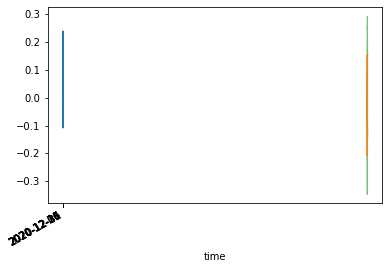

In [65]:
ax =ls_w_outliers[0]["2020-12-01":]['players_logged_diff'].plot(label = "Truth")

pred.predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:,0],
                   pred_conf.iloc[:,1], color = 'g', alpha = 0.5)

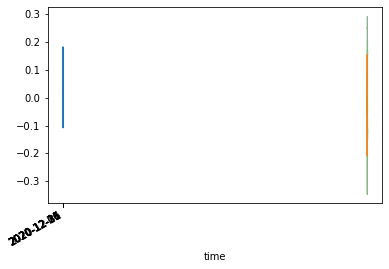

In [66]:
ax =ls_w_outliers[1]["2020-12-01":]['players_logged_diff'].plot(label = "Truth")

pred.predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:,0],
                   pred_conf.iloc[:,1], color = 'g', alpha = 0.5)

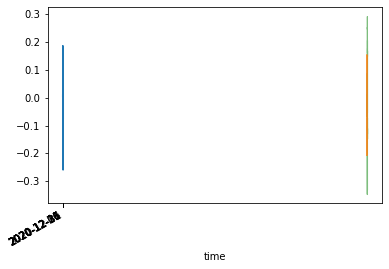

In [67]:
ax =ls_w_outliers[2]["2020-12-01":]['players_logged_diff'].plot(label = "Truth")

pred.predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:,0],
                   pred_conf.iloc[:,1], color = 'g', alpha = 0.5)

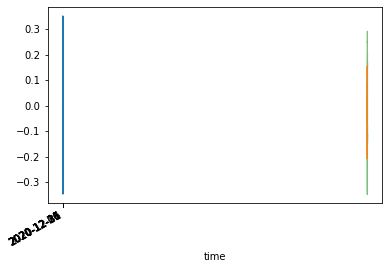

In [68]:
ax =ls_w_outliers[3]["2020-12-01":]['players_logged_diff'].plot(label = "Truth")

pred.predicted_mean.plot(ax = ax, label = "Forecasted", alpha = 0.8)
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:,0],
                   pred_conf.iloc[:,1], color = 'g', alpha = 0.5)

In [69]:
# and we generate mse for each df. the last is best because this is tf model testing on tf data.

for df in ls_w_outliers:
    forecasted = pred.predicted_mean
    truth = df["2020-12-15":]['%chg_players']
    mse = ((forecasted - truth) ** 2).mean()
    print(mse)

0.012571750265236848
0.012270643882882331
0.020727579612666816
0.007292223818158791


### Conclusions on our Control Model

While this model constructed solely from Team Fortress 2 data can be said to be viable from our summary stats, our mean squared error is much higher than our amalgamized model. This suggests that Team Fortress 2 is not as effective at predicting trends than an amalgamization of all of our data being used to predict trends. 

In [70]:
# we save all of our constructed models for use in the next notebook

import pickle

models = [csgo_model,
dota_model,
rl_model,
tf_model,
mean_model]

names = ["models/csgo_model.pkl",
"models/dota_model.pkl",
"models/rl_model.pkl",
"models/tf_model.pkl",
"models/mean_model.pkl"]

for i in range(len(models)):
    with open(names[i], 'wb') as file:
        pickle.dump(models[i], file)

In [71]:
# we also save our testing dataframes, those that retain outliers. 

names = ['csgo_test.csv',
        'dota_test.csv',
        'rl_test.csv',
        'tf_test.csv']

for i in range(len(ls_w_outliers)):
    ls_w_outliers[i].to_csv('data/Test/'+names[i])

## Next:

In the next notebook, we will compare our models and describe the pros and cons of each, while also using models to find interesting points in the future. We will also provide our recommendations to those looking to utilize our findings, and conclude with thoughts on how our investigation could have yeilded more insight into these data. 